In [369]:
%pip install scikit-learn

  Using cached scikit_learn-1.4.1.post1-cp310-cp310-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached scipy-1.12.0-cp310-cp310-macosx_12_0_arm64.whl.metadata (112 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.3.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.4.1.post1-cp310-cp310-macosx_12_0_arm64.whl (10.4 MB)
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Using cached scipy-1.12.0-cp310-cp310-macosx_12_0_arm64.whl (31.4 MB)
Using cached threadpoolctl-3.3.0-py3-none-any.whl (17 kB)

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torchview import draw_graph  # attempts to visualize computational graphs
import matplotlib.pyplot as plt
import ffmpeg_quality_metrics as ffqm  # for VMAF calculation
from torch.optim.lr_scheduler import ReduceLROnPlateau
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from PIL import Image
import matplotlib.image as mpimg
import cv2
import os
import random
import subprocess
import json
import numpy as np
import re   # for regular expressions
import csv
from collections import defaultdict
import pandas as pd
import tqdm
import time
import psutil
import pickle
import scipy.stats as st 

import warnings
warnings.filterwarnings('ignore')

# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


billie.mp4
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/billie.mp4
3183
printing frame number: 2709


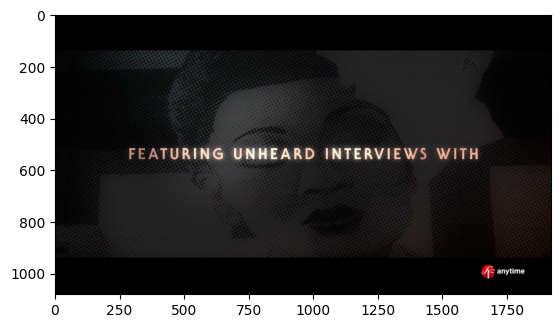

In [145]:
# input video data, training set

train = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train"
random_video = random.choice(os.listdir(train))
print(random_video)

video_path = os.path.join(train, random_video)
print(video_path)

cap = cv2.VideoCapture(video_path)

cap_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(cap_length)

random_frame = random.randrange(0, cap_length)
print("printing frame number:", random_frame)

cap.set(cv2.CAP_PROP_POS_FRAMES, 1000)  # frame 1000

ret, frame = cap.read()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  

if ret:
    plt.imshow(frame_rgb)
    plt.show()
    
cap.release()
cv2.destroyAllWindows()


domestic-disturbance-2001.mp4
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_test/domestic-disturbance-2001.mp4
4711
printing frame number: 4223


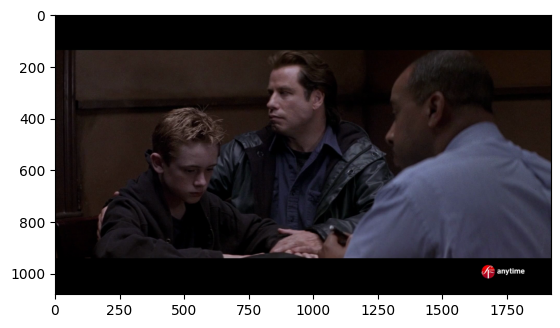

In [149]:
# input video data, test set 

test = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_test"
random_video = random.choice(os.listdir(test))
print(random_video)

video_path = os.path.join(test, random_video)
print(video_path)

cap = cv2.VideoCapture(video_path)

cap_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(cap_length)

random_frame = random.randrange(0, cap_length)
print("printing frame number:", random_frame)

cap.set(cv2.CAP_PROP_POS_FRAMES, 1000)  # frame 1000

ret, frame = cap.read()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  

if ret:
    plt.imshow(frame_rgb)
    plt.show()
    
cap.release()
cv2.destroyAllWindows()

In [147]:
# Compression of videos
compression_levels = [23, 37, 51]       # 37 är mittemellan 23 och 51

for video in os.listdir(train):
    video_path = os.path.join(train, video)
    if not os.path.isfile(video_path):
        continue                   # skip the current iteration if video_path is not a file
    
    
    # level = random.choice(compression_levels)
    
    for level in compression_levels:
    # Construct the compressed file path
        compressed_filename = f"compressed_{level}_{video}"
    
        compressed_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data_ALL", compressed_filename)
        
        # Compress the video
        subprocess.run(["ffmpeg", "-i", video_path, "-c:v", "libx264", "-crf", str(level), compressed_path])

        vmaf_command = [
            "ffmpeg",
            "-i", video_path,
            "-i", compressed_path,
            "-lavfi", f"[0:v][1:v]libvmaf=psnr=1:ssim=1:ms_ssim=1:log_fmt=json:log_path=vmaf_log_{level}_{video}.json",
            "-f", "null", "-"
        ]
        subprocess.run(vmaf_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/ktietz/demo/mc3/conda-bld/ffmpeg_1628925491858/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57

In [150]:
# Compression of test data
# compression_levels = [23, 50, 75]
compression_levels = [23, 37, 51] 

for video in os.listdir(test):
    video_path = os.path.join(test, video)
    if not os.path.isfile(video_path):
        continue                    
    
    # level = random.choice(compression_levels)
    
    for level in compression_levels:
    
        compressed_filename = f"compressed_{level}_{video}"

        compressed_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_TEST_videos_ALL", compressed_filename)
        
        # Compress the video
        subprocess.run(["ffmpeg", "-i", video_path, "-c:v", "libx264", "-crf", str(level), compressed_path])

        vmaf_command = [
            "ffmpeg",
            "-i", video_path,
            "-i", compressed_path,
            "-lavfi", f"[0:v][1:v]libvmaf=psnr=1:ssim=1:ms_ssim=1:log_fmt=json:log_path=vmaf_log_{level}_{video}.json",
            "-f", "null", "-"
        ]
        subprocess.run(vmaf_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/ktietz/demo/mc3/conda-bld/ffmpeg_1628925491858/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57

In [154]:
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train")))    
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data_ALL")))

print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_test")))    
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_TEST_videos_ALL")))



71
210
18
51


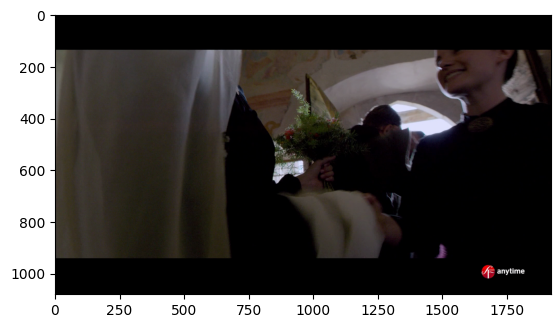

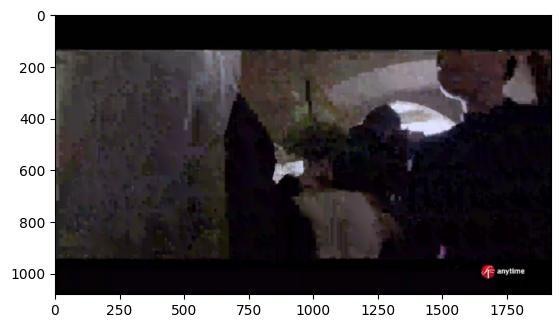

In [3]:
# Display frames with different compression levels
compressed_train = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data2"

video_path_0 = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data/compressed_0_a-hidden-life.mp4"
video_path_23 = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data/compressed_23_a-hidden-life.mp4"
video_path_50 = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data/compressed_50_a-hidden-life.mp4"
video_path_75 = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data/compressed_75_a-hidden-life.mp4"
    
cap_0 = cv2.VideoCapture(video_path_0)
cap_75 = cv2.VideoCapture(video_path_75)

cap_0.set(cv2.CAP_PROP_POS_FRAMES, 1000)
cap_75.set(cv2.CAP_PROP_POS_FRAMES, 1000)

ret_0, frame_0 = cap_0.read()
frame_rgb_0 = cv2.cvtColor(frame_0, cv2.COLOR_BGR2RGB)   

if ret_0:
    plt.imshow(frame_rgb_0)
    plt.show()
    
    
ret_75, frame_75 = cap_75.read()
frame_rgb_75 = cv2.cvtColor(frame_75, cv2.COLOR_BGR2RGB)   

if ret_75:
    plt.imshow(frame_rgb_75)
    plt.show()
    

im_0 = Image.fromarray(frame_0)
im_75 = Image.fromarray(frame_75)
im_0.save("im0_TEST.png")
im_75.save("im75_TEST.png")

cap_0.release()
cap_75.release()
cv2.destroyAllWindows()

In [103]:
# Contol frame rate in dataset

fps_list = []
for video in os.listdir(train):
    video_path = str(os.path.join(train, video))

    original_cap = cv2.VideoCapture(video_path)
    fps = int(original_cap.get(cv2.CAP_PROP_FPS))
    original_frame_count = int(original_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps_list.append(fps)
    
    print(video_path, fps)
    original_cap.release()
    
# print(min(fps_list))
# print(max(fps_list))

/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/maria-wern-svart-fjaril.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/army-of-darkness.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/wallander-forsvunnen.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/the-player.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/its-a-mad-mad-mad-mad-world.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/the-mothman-prophecies.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/road-house.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/knife-fight.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/maria-wern-alla-de-stillsamma-doda.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/tiny-tim-king-for-a-day.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/satans-slaves.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/silent-

OpenCV: Couldn't read video stream from file "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/.DS_Store"


/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/wheel-of-fortune-and-fantasy.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/maria-wern-drommen-forde-dig-vilse.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/bortom-tingri.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/son-of-a-gun.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/rocky-balboa.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/gone-in-60-seconds-1974.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/green-book.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/chitty-chitty-bang-bang.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/les-choses-quon-dit-les-choses-quon-fait.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/delicatessen.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/maria-wern-drommar-ur-sno.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data

In [156]:
# Dataset with frames, ≈ 1 frame / 10 seconds

compressed_train = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data_ALL"
nr = 1

video_files = sorted(os.listdir(compressed_train))

for video in video_files:
    video_path = os.path.join(compressed_train, video)
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frameNr = 0
    
    while True:
        ret, frame = cap.read()
        
        if ret:
            if frameNr % 250 == 0:
                # Save every 250th frame
                cv2.imwrite(f'/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed_ALL/train_{nr}_{video}_frame{frameNr}.png', frame)
                nr += 1
        else:
            break
        
        frameNr += 1
    
    cap.release()


In [7]:
# Dataset with REFERENCE-frames, kör ej igen

nr = 1

video_files = sorted(os.listdir(train))

for video in video_files:
    video_path = os.path.join(train, video)
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frameNr = 0
    
    while True:
        ret, frame = cap.read()
        
        if ret:
            if frameNr % 250 == 0:
                # Save every 250th frame
                cv2.imwrite(f'/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train/train_{nr}_{video}_frame{frameNr}.png', frame)
                nr += 1
        else:
            break
        
        frameNr += 1
    
    cap.release()


OpenCV: Couldn't read video stream from file "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/.DS_Store"


In [157]:
# dataset with png-images TEST SET

compressed_test = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_TEST_videos_ALL"
nr = 1

video_files = sorted(os.listdir(compressed_test))

for video in video_files:
    video_path = os.path.join(compressed_test, video)
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frameNr = 0
    
    while True:
        ret, frame = cap.read()
        
        if ret:
            if frameNr % 250 == 0:
                # Save every 250th frame
                cv2.imwrite(f'/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_compressed_ALL/TEST_{nr}_{video}_frame{frameNr}.png', frame)
                nr += 1
        else:
            break
        
        frameNr += 1
    
    cap.release()

In [27]:
# dataset with REFERENCE-frames TEST SET, kör ej igen!

nr = 1

video_files = sorted(os.listdir(test))

for video in video_files:
    video_path = os.path.join(test, video)
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frameNr = 0
    
    while True:
        ret, frame = cap.read()
        
        if ret:
            if frameNr % 250 == 0:
                # Save every 250th frame
                cv2.imwrite(f'/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST/TEST_{nr}_{video}_frame{frameNr}.png', frame)
                nr += 1
        else:
            break
        
        frameNr += 1
    
    cap.release()

OpenCV: Couldn't read video stream from file "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_test/.DS_Store"


/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train/train_359_maria-wern-alla-de-stillsamma-doda.mp4_frame1000.png
/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed2/train_633_compressed_75_maria-wern-alla-de-stillsamma-doda.mp4_frame1000.png


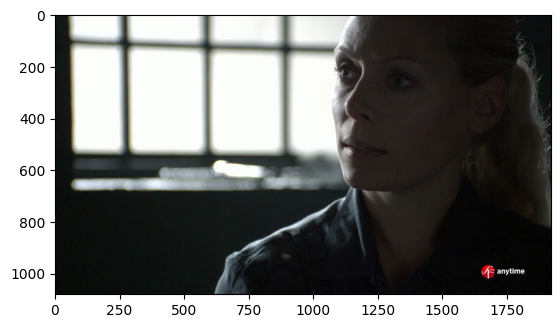

In [3]:
"""
VMAF on cropped frames
Algorithm:
1) Find all uncompressed frame versions. 
2) Crop in a predetermined amount of patches, store in a new folder with descriptive names
3) loop through folder and calculate VMAF, store VMAF values in a new file 
"""
    

In [9]:
# Reference frames CROP, training set

input_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train"
output_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop_png"
crop_size = (224, 224)   # default input size of DenseNet-121

image_files = [f for f in os.listdir(input_folder) if f.endswith(('.png'))]

for filename in image_files:
    im_path = os.path.join(input_folder, filename)
    im = Image.open(im_path)
    width, height = im.size

    num_chunks_x = width // crop_size[0]         # number of columns
    num_chunks_y = height // crop_size[1]        # number of rows

    for i in range(0, num_chunks_x):
        for j in range(0, num_chunks_y):
            
            left = i * crop_size[0]
            top = j * crop_size[1]
            right = left + crop_size[0]
            bottom = top + crop_size[1]

            cropped = im.crop((left, top, right, bottom))
            
            location_info = ""
            if i == 0:
                location_info += "left_"
            elif i == num_chunks_x - 1:
                location_info += "right_"
            if j == 0:
                location_info += "top"
            elif j == num_chunks_y - 1:
                location_info += "bottom"
                
            if left <= 960 <= right and top <= 540 <= bottom:   # center of the frame
                location_info += "center_"
                
            
            pos_x = left
            pos_y = top
            
            output_filename = f"{os.path.splitext(filename)[0]}_{location_info}_start_{pos_x}_{pos_y}.png"
            output_path = os.path.join(output_folder, output_filename)
            cropped.save(output_path)

            """output_filename = f"{os.path.splitext(filename)[0]}_{i}_{j}.jpg"
            output_path = os.path.join(output_folder, output_filename)
            cropped.save(output_path)"""

    im.close()


In [159]:
# compressed frames CROP, training set

input_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed_ALL"
output_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_ALL"
crop_size = (224, 224)   

image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png'))]

for filename in image_files:
    im_path = os.path.join(input_folder, filename)
    im = Image.open(im_path)
    width, height = im.size

    num_chunks_x = width // crop_size[0]        
    num_chunks_y = height // crop_size[1]        

    for i in range(0, num_chunks_x):
        for j in range(0, num_chunks_y):
            
            left = i * crop_size[0]
            top = j * crop_size[1]
            right = left + crop_size[0]
            bottom = top + crop_size[1]

            cropped = im.crop((left, top, right, bottom))
            
            location_info = ""
            if i == 0:
                location_info += "left_"
            elif i == num_chunks_x - 1:
                location_info += "right_"
            if j == 0:
                location_info += "top"
            elif j == num_chunks_y - 1:
                location_info += "bottom"
                
            if left <= 960 <= right and top <= 540 <= bottom:   
                location_info += "center_"
                
            
            pos_x = left
            pos_y = top
            
            output_filename = f"{os.path.splitext(filename)[0]}_{location_info}_start_{pos_x}_{pos_y}.png"
            output_path = os.path.join(output_folder, output_filename)
            cropped.save(output_path)

            """output_filename = f"{os.path.splitext(filename)[0]}_{i}_{j}.jpg"
            output_path = os.path.join(output_folder, output_filename)
            cropped.save(output_path)"""

    im.close()

In [160]:
# compressed frames CROP, test data

input_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_compressed_ALL"
output_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png_ALL"
crop_size = (224, 224)   

image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png'))]

for filename in image_files:
    im_path = os.path.join(input_folder, filename)
    im = Image.open(im_path)
    width, height = im.size

    num_chunks_x = width // crop_size[0]        
    num_chunks_y = height // crop_size[1]        

    for i in range(0, num_chunks_x):
        for j in range(0, num_chunks_y):
            
            left = i * crop_size[0]
            top = j * crop_size[1]
            right = left + crop_size[0]
            bottom = top + crop_size[1]

            cropped = im.crop((left, top, right, bottom))
            
            location_info = ""
            if i == 0:
                location_info += "left_"
            elif i == num_chunks_x - 1:
                location_info += "right_"
            if j == 0:
                location_info += "top"
            elif j == num_chunks_y - 1:
                location_info += "bottom"
                
            if left <= 960 <= right and top <= 540 <= bottom:   
                location_info += "center_"
                
            
            pos_x = left
            pos_y = top
            
            output_filename = f"{os.path.splitext(filename)[0]}_{location_info}_start_{pos_x}_{pos_y}.png"
            output_path = os.path.join(output_folder, output_filename)
            cropped.save(output_path)


    im.close()


In [29]:
# Reference frames CROP, test data

input_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST"
output_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_crop_png"
crop_size = (224, 224)   

image_files = [f for f in os.listdir(input_folder) if f.endswith(('.png'))]

for filename in image_files:
    im_path = os.path.join(input_folder, filename)
    im = Image.open(im_path)
    width, height = im.size

    num_chunks_x = width // crop_size[0]         
    num_chunks_y = height // crop_size[1]        

    for i in range(0, num_chunks_x):
        for j in range(0, num_chunks_y):
            
            left = i * crop_size[0]
            top = j * crop_size[1]
            right = left + crop_size[0]
            bottom = top + crop_size[1]

            cropped = im.crop((left, top, right, bottom))
            
            location_info = ""
            if i == 0:
                location_info += "left_"
            elif i == num_chunks_x - 1:
                location_info += "right_"
            if j == 0:
                location_info += "top"
            elif j == num_chunks_y - 1:
                location_info += "bottom"
                
            if left <= 960 <= right and top <= 540 <= bottom:   
                location_info += "center_"
                
            
            pos_x = left
            pos_y = top
            
            output_filename = f"{os.path.splitext(filename)[0]}_{location_info}_start_{pos_x}_{pos_y}.png"
            output_path = os.path.join(output_folder, output_filename)
            cropped.save(output_path)


    im.close()

In [86]:
# Check if lengths are correct

print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png")))
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop_png")))

print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_crop_png")))
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png")))

25952
25952
5920
5920


(1080, 1920, 3)
start row 	-  540
end row 	-  764
start column 	-  540
end column 	-  764
(224, 224, 3)


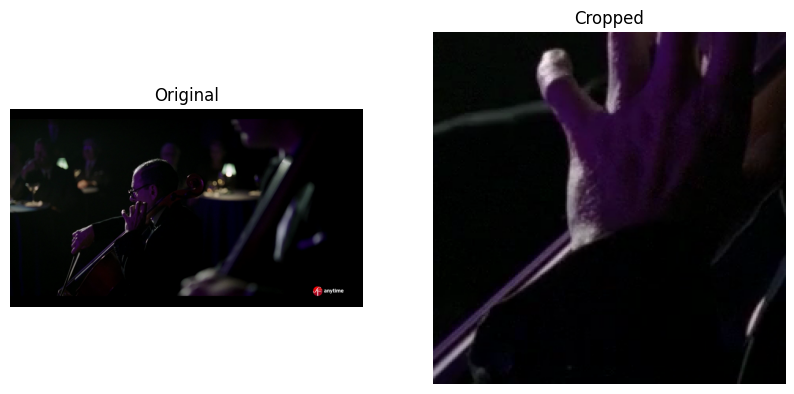

In [131]:
# Center crop test, not used

image_shape = frame_rgb.shape

print(frame_rgb.shape)

length = 224
width = 224

start_row = 540
start_column = start_row

end_row = length + start_row

end_column = width + start_column

print("start row \t- ", start_row)
print("end row \t- ", end_row)
print("start column \t- ", start_column)
print("end column \t- ", end_column)

image_cropped = frame_rgb[start_row:end_row, start_column:end_column]


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

ax1.axis("off")
ax1.title.set_text('Original')

ax2.axis("off")
ax2.title.set_text("Cropped")

ax1.imshow(frame_rgb)
ax2.imshow(image_cropped)

print(image_cropped.shape)     # (224, 224, 3)


In [170]:
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop_png")))
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_ALL")))

print(25952 * 3)

print(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop_png")[0])
print(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_ALL")[0])

25952
77856
77856
train_168_detroit.mp4_frame1750_top_start_672_0.png
train_1022_compressed_37_gone-in-60-seconds-1974.mp4_frame1500_top_start_896_0.png


In [173]:
def extract_details_comp(path):
    """
    Extracts movie name, frame number, and crop details from the path.
    """
    components = path.split("_")
    compressed = components[7]
    movie_name = components[8]
    frame_number = components[9]
    crop_details = "_".join(components[-2:])
    return compressed, movie_name, frame_number, crop_details


compressed_crops_23 = []
compressed_crops_37 = []
compressed_crops_51 = []
for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_ALL"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_ALL", image)
    
    components = im_path.split("_")
    
print(components)
 




['/Users/kajsalidin/Desktop/nr-vqa-vmaf/images', 'train', 'comp', 'crop', 'ALL/train', '1905', 'compressed', '51', 'knives-out.mp4', 'frame3000', '', 'start', '1344', '448.png']


In [186]:
reference_crops = []
compressed_crops_23 = []
compressed_crops_37 = []
compressed_crops_51 = []

for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop_png"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop_png", image)
    
    reference_crops.append(im_path)

for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_ALL"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_ALL", image)
    
    components = im_path.split("_")
    compressed = components[7]
     
    if compressed == "23":
        compressed_crops_23.append(im_path)
        
    elif compressed == "37":
        compressed_crops_37.append(im_path)
        
    elif compressed == "51":
        compressed_crops_51.append(im_path)
        

def extract_details_ref(path):
    components = path.split("_")
    movie_name = components[5]
    frame_number = components[6]
    crop_details = "_".join(components[-2:])
    return movie_name, frame_number, crop_details


def extract_details_comp(path):
    components = path.split("_")
    movie_name = components[8]
    frame_number = components[9]
    crop_details = "_".join(components[-2:])
    return movie_name, frame_number, crop_details


def sort_by_details_ref(path):
    movie_name, frame_number, crop_details = extract_details_ref(path)
    return movie_name, frame_number, crop_details


def sort_by_details_comp(path):
    movie_name, frame_number, crop_details = extract_details_comp(path)
    return movie_name, frame_number, crop_details


reference_sorted = sorted(reference_crops, key=sort_by_details_ref)
compressed_sorted_23 = sorted(compressed_crops_23, key=sort_by_details_comp)
compressed_sorted_37 = sorted(compressed_crops_37, key=sort_by_details_comp)
compressed_sorted_51 = sorted(compressed_crops_51, key=sort_by_details_comp)

print(reference_sorted[31])
print(compressed_sorted_51[31])

/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop_png/train_1_a-hidden-life.mp4_frame0_bottom_start_896_672.png
/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_ALL/train_1623_compressed_51_a-hidden-life.mp4_frame0_bottom_start_896_672.png


In [187]:
"""
VMAF terminal command:
ffmpeg-quality-metrics distorted.jpg reference.jpg --metrics vmaf

where ffmpeg - find location of ffmpeg library

Python Subprocess:
From https://www.datacamp.com/tutorial/python-subprocess : 
It's like giving commands to your computer using Python instead of typing them directly into the command prompt. This module makes it easy to automate tasks and integrate other programs with your Python code.
This can be useful for tasks such as log analysis, data processing, and text manipulation.

https://github.com/Netflix/vmaf/issues/1168 : 
When evaluating a single frame, VMAF will set the "motion" feature value to "0", meaning depriving of the motion masking effect from its estimation.

"""

"""def process_image(dist_im, ref_im):
    command = ['/opt/homebrew/bin/ffmpeg', '-i', dist_im, '-i', ref_im, '-lavfi', 'libvmaf', '-f', 'null', '-']
    # command = ['/opt/homebrew/bin/ffmpeg-quality-metrics', dist_im, ref_im, '--metrics', 'vmaf']
    output = subprocess.check_output(command)     # os.system()?
    return output.decode('utf-8')
    # output = os.system(f'ffmpeg-quality-metrics {dist_im} {ref_im} --metrics vmaf')
"""

output_file = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/vmaf_values_train_ALL.csv" 
compression_levels = [23, 37, 51]

for comp in compression_levels:
    if comp == 23:
        if len(reference_sorted) != len(compressed_sorted_23):
            print("Error: The number of files in the two folders is not the same.")
            exit()

        vmaf_scores = []
        count = 0
            
        for filename1, filename2 in zip(reference_sorted, compressed_sorted_23):
                image_path_ref = filename1
                image_path_dist = filename2
                
                command = ['/opt/homebrew/bin/ffmpeg', '-i', image_path_dist, '-i', image_path_ref, '-lavfi', 'libvmaf', '-f', 'null', '-']
                output = subprocess.run(command, capture_output=True, text=True)
                
                pattern = re.compile(r'VMAF score: (\d+\.\d+)')  # (\d+\.\d+) matches the VMAF score
                match = pattern.search(str(output))
                
                if match:
                    vmaf_score = match.group(1)
                    vmaf_scores.append([vmaf_score, image_path_dist])
                    count +=1
                
        print(count)
        
        
    elif comp == 37:
        if len(reference_sorted) != len(compressed_sorted_37):
            print("Error: The number of files in the two folders is not the same.")
            exit()
            
        for filename1, filename2 in zip(reference_sorted, compressed_sorted_37):
                image_path_ref = filename1
                image_path_dist = filename2
                
                command = ['/opt/homebrew/bin/ffmpeg', '-i', image_path_dist, '-i', image_path_ref, '-lavfi', 'libvmaf', '-f', 'null', '-']
                output = subprocess.run(command, capture_output=True, text=True)
                
                pattern = re.compile(r'VMAF score: (\d+\.\d+)')  # (\d+\.\d+) matches the VMAF score
                match = pattern.search(str(output))
                
                if match:
                    vmaf_score = match.group(1)
                    vmaf_scores.append([vmaf_score, image_path_dist])
                    count +=1
                
        print(count)
        
    elif comp == 51:
        if len(reference_sorted) != len(compressed_sorted_51):
            print("Error: The number of files in the two folders is not the same.")
            exit()

            
        for filename1, filename2 in zip(reference_sorted, compressed_sorted_51):
                image_path_ref = filename1
                image_path_dist = filename2
                
                command = ['/opt/homebrew/bin/ffmpeg', '-i', image_path_dist, '-i', image_path_ref, '-lavfi', 'libvmaf', '-f', 'null', '-']
                output = subprocess.run(command, capture_output=True, text=True)
                
                pattern = re.compile(r'VMAF score: (\d+\.\d+)')  # (\d+\.\d+) matches the VMAF score
                match = pattern.search(str(output))
                
                if match:
                    vmaf_score = match.group(1)
                    vmaf_scores.append([vmaf_score, image_path_dist])
                    count +=1
                
        print(count)
            
            
with open(output_file, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['VMAF Score', 'Filename'])
    csv_writer.writerows(vmaf_scores)
       
   

25952
51904
77856


/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train/train_760_vendetta.mp4_frame0.png
/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed_ALL/train_1571_compressed_37_vendetta.mp4_frame0.png


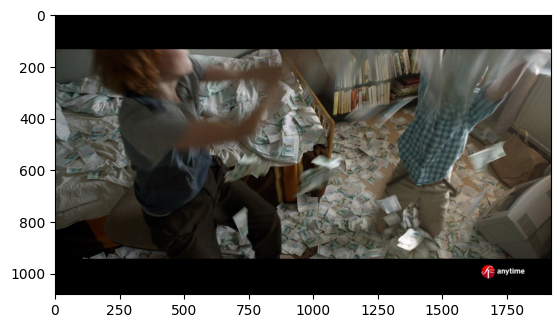

In [202]:
reference_frames = []
compressed_frames_23 = []
compressed_frames_37 = []
compressed_frames_51 = []

for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train", image)
    
    reference_frames.append(im_path)
    
for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed_ALL"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed_ALL", image)
    
    components = im_path.split("_")
    compressed = components[6]
     
    if compressed == "23":
        compressed_frames_23.append(im_path)
        
    elif compressed == "37":
        compressed_frames_37.append(im_path)
        
    elif compressed == "51":
        compressed_frames_51.append(im_path)
        

def sort_by_movie_ref(path):
    return path.split("_")[3]    # film name
   
def sort_by_movie_comp(path):
    return path.split("_")[7]     # film name


def sort_by_frame(path):
    return path.split("_")[-1]       


reference_sorted = sorted(reference_frames, key=sort_by_movie_ref)
compressed_sorted_23 = sorted(compressed_frames_23, key=sort_by_movie_comp)
compressed_sorted_37 = sorted(compressed_frames_37, key=sort_by_movie_comp)
compressed_sorted_51 = sorted(compressed_frames_51, key=sort_by_movie_comp)

reference_sorted_by_frames = sorted(reference_sorted, key=sort_by_frame)
compressed_sorted_by_frames_51 = sorted(compressed_sorted_51, key=sort_by_frame)
compressed_sorted_by_frames_37 = sorted(compressed_sorted_37, key=sort_by_frame)
compressed_sorted_by_frames_23 = sorted(compressed_sorted_23, key=sort_by_frame)

# print(compressed_sorted)

print(reference_sorted_by_frames[65])
print(compressed_sorted_by_frames_37[65])

plt.imshow(plt.imread(reference_sorted_by_frames[250]))  

In [204]:
# VMAF on full frames, for analysis
output_file2 = "vmaf_on_full_frames_train_ALL.csv" 


for comp in compression_levels:
    if comp == 23:
        if len(reference_sorted_by_frames) != len(compressed_sorted_by_frames_23):
            print("Error: The number of files in the two folders is not the same.")
            exit()

        vmaf_scores = []
        count = 0
            
        for filename1, filename2 in zip(reference_sorted_by_frames, compressed_sorted_by_frames_23):
                image_path_ref = filename1
                image_path_dist = filename2
                
                command = ['/opt/homebrew/bin/ffmpeg', '-i', image_path_dist, '-i', image_path_ref, '-lavfi', 'libvmaf', '-f', 'null', '-']
                output = subprocess.run(command, capture_output=True, text=True)
                
                pattern = re.compile(r'VMAF score: (\d+\.\d+)')  # (\d+\.\d+) matches the VMAF score
                match = pattern.search(str(output))
                
                if match:
                    vmaf_score = match.group(1)
                    vmaf_scores.append([vmaf_score, image_path_dist])
                    count +=1
                
        print(count)
        
        
    elif comp == 37:
        if len(reference_sorted_by_frames) != len(compressed_sorted_by_frames_37):
            print("Error: The number of files in the two folders is not the same.")
            exit()
            
        for filename1, filename2 in zip(reference_sorted_by_frames, compressed_sorted_by_frames_37):
                image_path_ref = filename1
                image_path_dist = filename2
                
                command = ['/opt/homebrew/bin/ffmpeg', '-i', image_path_dist, '-i', image_path_ref, '-lavfi', 'libvmaf', '-f', 'null', '-']
                output = subprocess.run(command, capture_output=True, text=True)
                
                pattern = re.compile(r'VMAF score: (\d+\.\d+)')  # (\d+\.\d+) matches the VMAF score
                match = pattern.search(str(output))
                
                if match:
                    vmaf_score = match.group(1)
                    vmaf_scores.append([vmaf_score, image_path_dist])
                    count +=1
                
        print(count)
        
    elif comp == 51:
        if len(reference_sorted_by_frames) != len(compressed_sorted_by_frames_51):
            print("Error: The number of files in the two folders is not the same.")
            exit()

            
        for filename1, filename2 in zip(reference_sorted_by_frames, compressed_sorted_by_frames_51):
                image_path_ref = filename1
                image_path_dist = filename2
                
                command = ['/opt/homebrew/bin/ffmpeg', '-i', image_path_dist, '-i', image_path_ref, '-lavfi', 'libvmaf', '-f', 'null', '-']
                output = subprocess.run(command, capture_output=True, text=True)
                
                pattern = re.compile(r'VMAF score: (\d+\.\d+)')  # (\d+\.\d+) matches the VMAF score
                match = pattern.search(str(output))
                
                if match:
                    vmaf_score = match.group(1)
                    vmaf_scores.append([vmaf_score, image_path_dist])
                    count +=1
                
        print(count)
            
            
with open(output_file2, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['VMAF Score', 'Filename'])
    csv_writer.writerows(vmaf_scores)

811
1622
2433


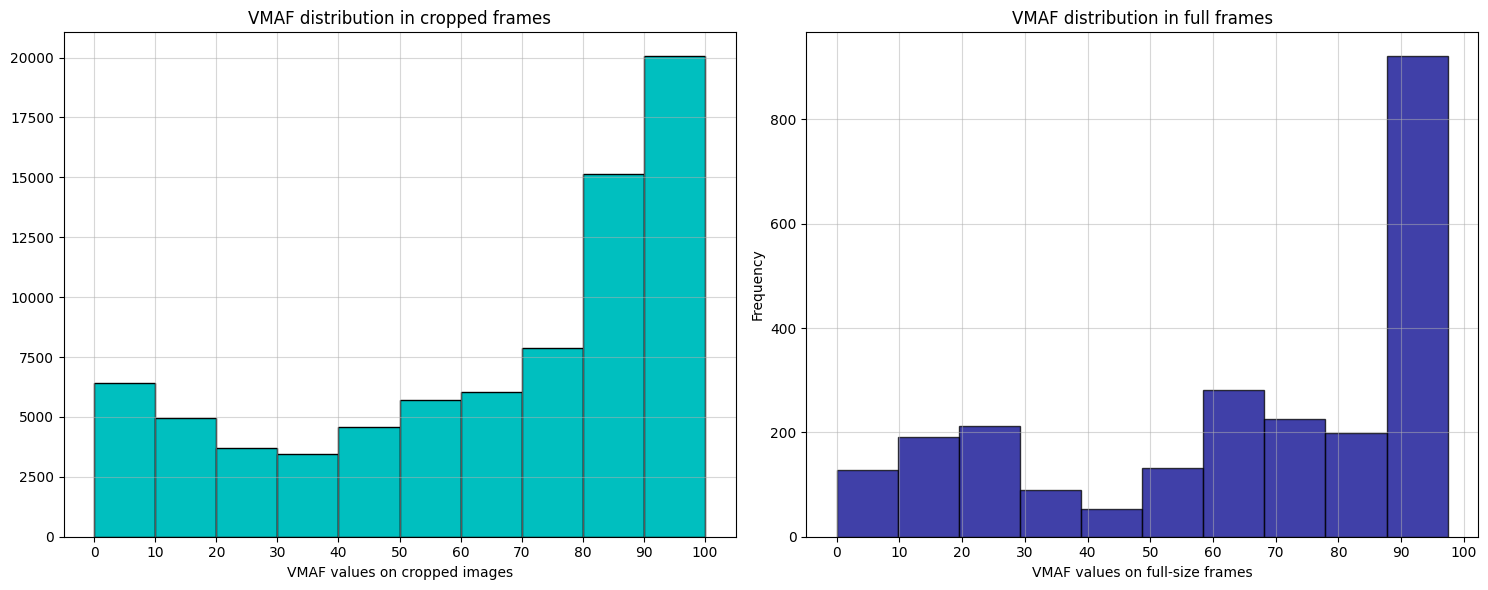

In [216]:
"""
Distribution of VMAF for analysis
"""

file = pd.read_csv("vmaf_values_train_ALL.csv")

file2 = pd.read_csv("vmaf_on_full_frames_train_ALL.csv")

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].hist(file.iloc[:, 0], edgecolor="k", color="c")
axs[0].grid(alpha=0.5)
axs[0].set_xlabel("VMAF values on cropped images")
axs[0].set_xticks(range(0, 101, 10))
axs[0].grid(alpha=0.5)
axs[0].set_title("VMAF distribution in cropped frames")

axs[1].hist(file2.iloc[:, 0], edgecolor="k", color="darkblue", alpha=0.75)
axs[1].set_xlabel("VMAF values on full-size frames")
axs[1].set_ylabel('Frequency')
axs[1].set_xticks(range(0, 101, 10))
axs[1].grid(alpha=0.5)
axs[1].set_title("VMAF distribution in full frames")

plt.tight_layout()
plt.show()



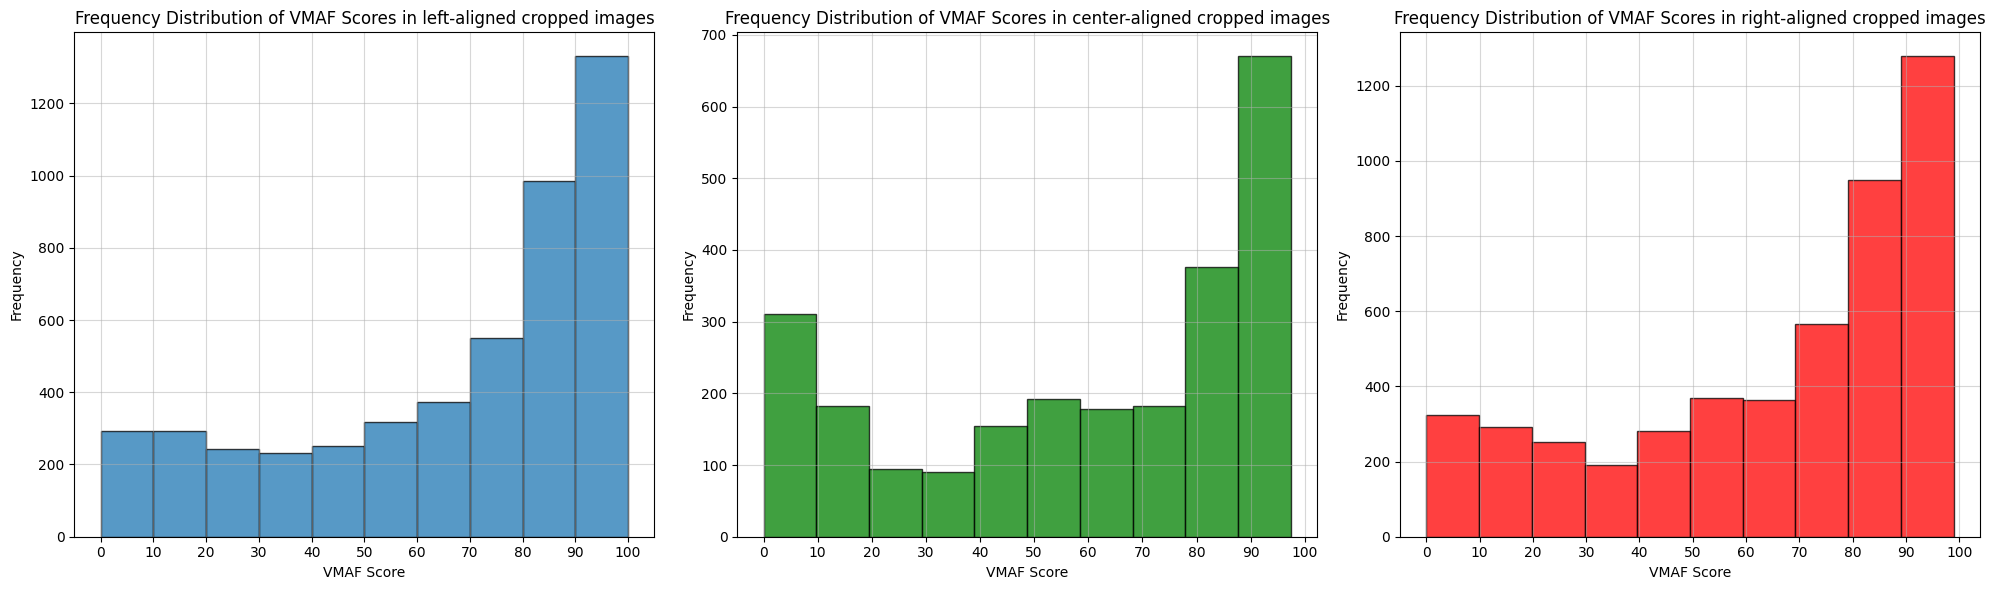

In [206]:
csv_file_path = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/vmaf_values_train_ALL.csv"

positions = []
left = []
right = []
bottom = []
top = []
center = []
corners = []

with open(csv_file_path, newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        vmaf_score = row[0]
        filename = row[1]
        
        position_info = filename.split('/')[-1].split('_')[6:-1]
        position = [vmaf_score, '_'.join(position_info)]
        positions.append(position)
        
        
    for pos in positions:
        if "center" in str(pos[1]):
            center.append(pos)
            
        elif "top" in str(pos[1]):
            top.append(pos)
            
            if "left" or "right" in str(pos[1]):
                corners.append(pos)
            
        elif "bottom" in str(pos[1]):
            bottom.append(pos)
            
            if "left" or "right" in str(pos[1]):
                corners.append(pos)
        
            
        elif "right" in str(pos[1]):
            right.append(pos)
            
        elif "left" in str(pos[1]):
            left.append(pos)
            

vmaf_left = [float(item[0]) for item in left]
vmaf_right = [float(item[0]) for item in right]
vmaf_center = [float(item[0]) for item in center]


fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].hist(sorted(vmaf_left), edgecolor="k", alpha=0.75)
axs[0].set_xlabel('VMAF Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Frequency Distribution of VMAF Scores in left-aligned cropped images')
axs[0].set_xticks(range(0, 101, 10))
axs[0].grid(alpha=0.5)

axs[1].hist(sorted(vmaf_center), edgecolor="k", color="g", alpha=0.75)
axs[1].set_xlabel('VMAF Score')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Frequency Distribution of VMAF Scores in center-aligned cropped images')
axs[1].set_xticks(range(0, 101, 10))
axs[1].grid(alpha=0.5)

axs[2].hist(sorted(vmaf_right), edgecolor="k", color="r", alpha=0.75)
axs[2].set_xlabel('VMAF Score')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Frequency Distribution of VMAF Scores in right-aligned cropped images')
axs[2].set_xticks(range(0, 101, 10))
axs[2].grid(alpha=0.5)

plt.tight_layout()
plt.show()

        

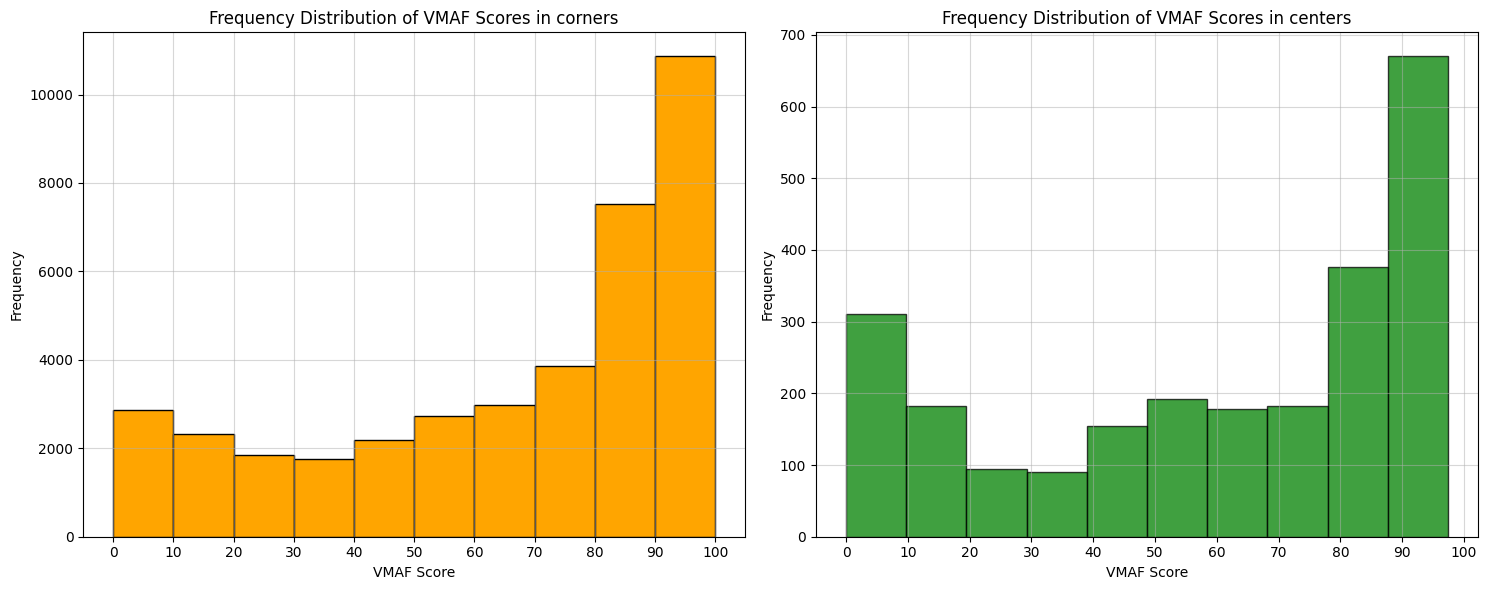

In [207]:
vmaf_corners = [float(item[0]) for item in corners]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].hist(sorted(vmaf_corners), color = "orange", edgecolor="k")
axs[0].set_xlabel('VMAF Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Frequency Distribution of VMAF Scores in corners')    # corners include left bottom, left top, right bottom, right top
axs[0].set_xticks(range(0, 101, 10))
axs[0].grid(alpha=0.5)

axs[1].hist(sorted(vmaf_center), color = "green", edgecolor="k", alpha=0.75)
axs[1].set_xlabel('VMAF Score')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Frequency Distribution of VMAF Scores in centers')
axs[1].set_xticks(range(0, 101, 10))
axs[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()


In [217]:
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_ALL")))
df = pd.read_csv('vmaf_values_train_ALL.csv')
print(df.shape[0])      

77856
77856


In [229]:
for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png_ALL"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png_ALL", image)
    components = im_path.split("_")
print(components[-2:])  

['672', '672.png']


In [234]:
reference_crops_test = []
compressed_crops_test_23 = []
compressed_crops_test_37 = []
compressed_crops_test_51 = []

def extract_details_ref(path):
    components = path.split("_")
    movie_name = components[5]
    frame_number = components[6]
    crop_details = "_".join(components[-2:])
    return movie_name, frame_number, crop_details


def extract_details_comp(path):
    components = path.split("_")
    movie_name = components[9]
    frame_number = components[10]
    crop_details = "_".join(components[-2:])
    return movie_name, frame_number, crop_details


def sort_by_details_ref(path):
    movie_name, frame_number, crop_details = extract_details_ref(path)
    return movie_name, frame_number, crop_details


def sort_by_details_comp(path):
    movie_name, frame_number, crop_details = extract_details_comp(path)
    return movie_name, frame_number, crop_details


for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_crop_png"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_crop_png", image)
    
    reference_crops_test.append(im_path)

for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png_ALL"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png_ALL", image)
    components = im_path.split("_")
    
    if components[8] == "23":
        compressed_crops_test_23.append(im_path)
        
    elif components[8] == "37":
        compressed_crops_test_37.append(im_path)
        
    elif components[8] == "51":
        compressed_crops_test_51.append(im_path)


reference_sorted_test = sorted(reference_crops_test, key=sort_by_details_ref)
compressed_sorted_test_23 = sorted(compressed_crops_test_23, key=sort_by_details_comp)
compressed_sorted_test_37 = sorted(compressed_crops_test_37, key=sort_by_details_comp)
compressed_sorted_test_51 = sorted(compressed_crops_test_51, key=sort_by_details_comp)

print(reference_sorted_test[265])
print(compressed_sorted_test_51[265])

/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_crop_png/TEST_9_apocalypse-now-final-cut.mp4_frame0__start_1344_224.png
/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png_ALL/TEST_379_compressed_51_apocalypse-now-final-cut.mp4_frame0__start_1344_224.png


In [235]:
# VMAF values TEST-set
output_file_test = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/vmaf_values_TEST_ALL.csv" 
compression_levels = [23, 37, 51]

for comp in compression_levels:
    if comp == 23:
        if len(reference_sorted_test) != len(compressed_sorted_test_23):
            print("Error: The number of files in the two folders is not the same.")
            exit()

        vmaf_scores = []
        count = 0
            
        for filename1, filename2 in zip(reference_sorted_test, compressed_sorted_test_23):
                image_path_ref = filename1
                image_path_dist = filename2
                
                command = ['/opt/homebrew/bin/ffmpeg', '-i', image_path_dist, '-i', image_path_ref, '-lavfi', 'libvmaf', '-f', 'null', '-']
                output = subprocess.run(command, capture_output=True, text=True)
                
                pattern = re.compile(r'VMAF score: (\d+\.\d+)')  # (\d+\.\d+) matches the VMAF score
                match = pattern.search(str(output))
                
                if match:
                    vmaf_score = match.group(1)
                    vmaf_scores.append([vmaf_score, image_path_dist])
                    count +=1
                
        print(count)
        
        
    elif comp == 37:
        if len(reference_sorted_test) != len(compressed_sorted_test_37):
            print("Error: The number of files in the two folders is not the same.")
            exit()
            
        for filename1, filename2 in zip(reference_sorted_test, compressed_sorted_test_37):
                image_path_ref = filename1
                image_path_dist = filename2
                
                command = ['/opt/homebrew/bin/ffmpeg', '-i', image_path_dist, '-i', image_path_ref, '-lavfi', 'libvmaf', '-f', 'null', '-']
                output = subprocess.run(command, capture_output=True, text=True)
                
                pattern = re.compile(r'VMAF score: (\d+\.\d+)')  # (\d+\.\d+) matches the VMAF score
                match = pattern.search(str(output))
                
                if match:
                    vmaf_score = match.group(1)
                    vmaf_scores.append([vmaf_score, image_path_dist])
                    count +=1
                
        print(count)
        
    elif comp == 51:
        if len(reference_sorted_test) != len(compressed_sorted_test_51):
            print("Error: The number of files in the two folders is not the same.")
            exit()

            
        for filename1, filename2 in zip(reference_sorted_test, compressed_sorted_test_51):
                image_path_ref = filename1
                image_path_dist = filename2
                
                command = ['/opt/homebrew/bin/ffmpeg', '-i', image_path_dist, '-i', image_path_ref, '-lavfi', 'libvmaf', '-f', 'null', '-']
                output = subprocess.run(command, capture_output=True, text=True)
                
                pattern = re.compile(r'VMAF score: (\d+\.\d+)')  # (\d+\.\d+) matches the VMAF score
                match = pattern.search(str(output))
                
                if match:
                    vmaf_score = match.group(1)
                    vmaf_scores.append([vmaf_score, image_path_dist])
                    count +=1
                
        print(count)
            
            
            
with open(output_file_test, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['VMAF Score', 'Filename'])
    csv_writer.writerows(vmaf_scores)

5920
11840
17760


86.86223
/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_ALL/train_284_compressed_23_knives-out.mp4_frame3250_top_start_1344_0.png


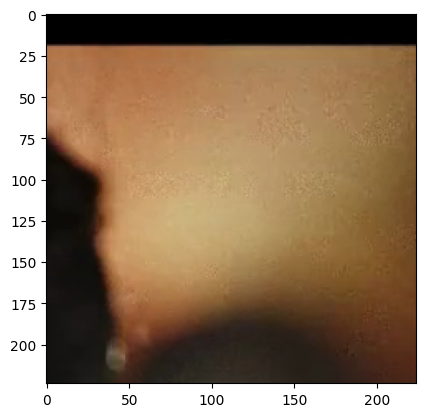

In [236]:
print(pd.read_csv("vmaf_values_train_ALL.csv").iloc[9000, 0])
print(os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_ALL", pd.read_csv("vmaf_values_train_ALL.csv").iloc[9000, 1]))
plt.imshow(mpimg.imread(os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_ALL", pd.read_csv("vmaf_values_train_ALL.csv").iloc[9000, 1])))

In [6]:
# Inspiration from: https://pandas.pydata.org/docs/user_guide/merging.html 

class ImagesAndLabelsDataset(Dataset): 
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)      # labels
        self.root_dir = root_dir
        self.transform = transform
        self.scaler = sklearn.preprocessing.StandardScaler()
        
        # Fit the scaler to VMAF scores
        self.scaler.fit(self.annotations.iloc[:, 0].values.reshape(-1, 1))
        
    def __len__(self):
        return len(self.annotations)
    
    def __getimage__(self, index):
        img_path = self.annotations.iloc[index, 1]
        return img_path
    
    def __getitem__(self, index):
        img_path = self.annotations.iloc[index, 1]
        try:
            image = mpimg.imread(img_path)
        except Exception as e:
            print(f"Error reading image at index {index}: {e}")
            return None
        
        
        y_label = self.annotations.iloc[index, 0]  # VMAF score
        
        # Normalize y_label using the previously created scaler
        normalized_vmaf = self.scaler.transform([[y_label]])[0][0]
        
        normalized_vmaf = torch.tensor(normalized_vmaf, dtype=torch.float32)   # standardized VMAF (between -1 and 1)
        norm = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])   # normalization, from https://pytorch.org/hub/pytorch_vision_densenet/
        
        if self.transform:
            image = self.transform(image)
            norm(image)
        
            
        return (image, normalized_vmaf, img_path)     # tuple of tensors and img_path
    
    

"""
To train DenseNet on train data:
1) loop over epochs (passes in dataset)
2) loop over minibatches
3) forward pass
4) compute loss
5) backward pass
6) upgrade parameters with optimizer (Adam)

"""
    

'\nTo train DenseNet on train data:\n1) loop over epochs (passes in dataset)\n2) loop over minibatches\n3) forward pass\n4) compute loss\n5) backward pass\n6) upgrade parameters with optimizer (Adam)\n\n'

In [7]:
data = ImagesAndLabelsDataset(csv_file = "vmaf_values_train_ALL.csv", root_dir = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_ALL", transform = transforms.ToTensor())
print(data[1])

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), tensor(1.0642), '/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_ALL/train_1_compressed_23_a-hidden-life.mp4_frame0_left__start_0_224.png')


In [8]:
# data = ImagesAndLabelsDataset(csv_file = "vmaf_values_train_ALL.csv", root_dir = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_ALL", transform = transforms.ToTensor())
# Shuffle, with seed for reproducability 
train_set, val_set = torch.utils.data.random_split(data, [0.9, 0.1], generator=torch.Generator().manual_seed(1))    # 10% validation 
train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=100)    # ändra till shuffle = True för träning
val_loader = DataLoader(dataset=val_set, shuffle=True, batch_size=100)

# Data loader combines a dataset and a sampler, and provides an iterable over the given dataset, easy access to the samples

In [240]:
print(len(train_set))
print(len(train_loader))

70071
701


'count = 0\nfor i, data in enumerate(train_loader, 0): \n    count +=1\n    '

In [522]:
# Glöm inte att standardisera testdata också
test_data = ImagesAndLabelsDataset(csv_file = "vmaf_values_TEST_ALL.csv", root_dir = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png_ALL", transform = transforms.ToTensor())
print(test_data.__getimage__(10000)) 
test_loader = DataLoader(dataset=test_data, shuffle=False, batch_size=100)
# test_loader = DataLoader(dataset=test_data, shuffle=False, batch_size=100)   # kanske till och med ännu större batch_size för testset?
# pickle-fil
# Fråga om det är bra practise att ha en metod __getimage__, köra att om filnamnet innehåller "center", dela upp i en dataloader, osv.
# måste slice:a testdatan i center, corner, edge etc. Top och bottom också?

/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png_ALL/TEST_313_compressed_37_robocop-2.mp4_frame0_top_start_224_0.png


In [246]:
# validation set? 
# train_data.__len__()
val_set.__len__()         # 2595
# train_set.__len__()     # 23357
# train_data[9000]      # vmaf values as torch.float32

7785

In [247]:
# From https://www.kaggle.com/code/leighplt/densenet121-pytorch
# X_train is the instance with attributes, y_train is the label of each instance
# output layer adjusted for regression instead of classifictaion 
# Single neuron for regression
# loss function: test with MSE and MAE
# efficient=True for efficient run

class DenseNet(nn.Module):
    def __init__(self, num_channels=3):     
        super().__init__()
        preloaded = models.densenet121(pretrained=True)
        self.features = preloaded.features
        self.features.conv0 = nn.Conv2d(num_channels, 64, 7, 2, 3)   # in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None
        """
        Including a bias term allows the model to learn a better representation of the data by shifting the activation function's output. 
        It effectively adds flexibility to the model's decision boundary, allowing it to fit more complex patterns in the data.
        """
        for param in self.features.parameters():  # Freeze all parameters in self.features
            param.requires_grad = False
           
        """self.dense = nn.Linear(50176, 10000)    # 224 * 224 * 3 = 37632  
        self.dense2 = nn.Linear(10000, 10000)
        self.dense3 = nn.Linear(10000, 1024)"""
        
        # nn.Sequential would have worked too 
        self.dense = nn.Linear(50176, 1024, bias=True)
        self.dense2 = nn.Linear(1024, 1024, bias=True)
        self.dense3 = nn.Linear(1024, 1024, bias=True)
        self.dense4 = nn.Linear(1024, 1024, bias=True)
        self.dense5 = nn.Linear(1024, 1024, bias=True)
        self.classifier = nn.Linear(1024, 1, bias=True)     # torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        # self.dense = nn.Linear(802816, 1024)
        
        # unfreeze the dense layers, use these for learning:
        for param in self.dense.parameters():
            param.requires_grad = True
            
        for param in self.dense2.parameters():
            param.requires_grad = True
            
        for param in self.dense3.parameters():
            param.requires_grad = True
            
        for param in self.dense4.parameters(): 
            param.requires_grad = True
            
        for param in self.dense5.parameters(): 
            param.requires_grad = True
        
        for param in self.classifier.parameters():     
            param.requires_grad = True
            
    
    # activation function, A rectified linear unit (ReLU) is an activation function that introduces the property of non-linearity to a deep learning model and solves the vanishing gradients issue.
    # Leaky ReLU can allow some negative values
    def forward(self, x):
        features = self.features(x)       # hidden layers, feature maps
        out = nn.LeakyReLU(features)     
        out = torch.flatten(out, 1)        # Flattens input by reshaping it into a one-dimensional tensor, from second dimension of input tensor
        out = self.dense(out)   
        out = nn.LeakyReLU(out)   # inplace=True ? - More efficient memory allocation but can prevent backward pass
        out = self.dense2(out)
        out = nn.LeakyReLU(out)
        out = self.dense3(out)
        out = nn.LeakyReLU(out)
        out = self.dense4(out)
        out = nn.LeakyReLU(out)
        out = self.dense5(out)
        out = nn.LeakyReLU(out)
        out = self.classifier(out)
        return out.squeeze(1)  # Ensure output is a 1D tensor, reduce array dimensionality, removes axis of length 1
    
    # kanske ta bort squeeze
    
    # Avg pooling smetar ut signalen men är billig


In [248]:
# Train model, from https://www.kaggle.com/code/leighplt/densenet121-pytorch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# batch_size = 100    # try some different sizes
model = DenseNet(num_channels=3)

model.to(device)

criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  
# scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

# try different learning rates for optimal results
# lr explosion test ?

In [249]:
def evaluate(model, dataloader):
    model.eval()
    losses = []
    with torch.no_grad():
        torch.manual_seed(2)
        for i, data in enumerate(dataloader, 0):     # 0 is start index
            inputs, labels, img_path = data
            
            y_pred = model(inputs)   
            
            # if i % 10 == 0:         # for quicker runtime
            loss = criterion(y_pred, labels)
            losses.append(loss.item())     # extract only loss, as a PyTorch float
            

    return sum(losses) / len(losses)

In [331]:
# training
train_losses = []
val_losses = []
batch_running_losses = []
num_epochs = 10       # linjär tidskomplexitet 

for epoch in range(num_epochs):
    start_epoch_time = time.time()
    model.train()
    running_loss = 0.0     # nollställs för varje epoch
    
    torch.manual_seed(2)        # samma distribution som validation loss
    for i, data in enumerate(train_loader, 0):      # 0 is start index
        """if i >= 2500:       # 2500 first data points in the shuffled dataset (around 10%)
            break """
        
        batch_running_loss = 0.0
        
        inputs, labels, img_path = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  
        
        outputs = model(inputs)     
        
        training_loss = criterion(outputs, labels)
        train_losses.append(training_loss.item()) 
        running_loss += training_loss.item()
        batch_running_loss += training_loss.item()
        
        with open("train_ALL.txt", "a") as f:
                f.write(str(training_loss.item()))
                f.write('\n')
        
        training_loss.backward()     # backward pass
        
        optimizer.step()             # step
        
        if i % 50 == 0:        
            val_loss = evaluate(model, val_loader)
            val_losses.append(val_loss)    
            with open("val_ALL.txt", "a") as f2:
                f2.write(str(val_loss))
                f2.write('\n')
                
        model.train()
            
    
        avg_loss_per_epoch = running_loss / len(train_loader)
        print(avg_loss_per_epoch)
        
        
    end_epoch_time = time.time()  # End timer for epoch
    epoch_time = end_epoch_time - start_epoch_time
    print(f"Epoch {epoch+1} took {epoch_time} seconds")
    print(f"Avg loss for epoch {epoch+1} is  {avg_loss_per_epoch}")


print("Done!")
    

7.222583808844508
11.015589824246613
106.52307912524519
108.70478243970666
115.11328995686965
121.81162617856188
128.140878892319
136.01031206813926
143.76032530258112
150.9957695061742
158.34948434435182
164.88054906216567
170.79879016304832
175.10062250635252
177.3747332215139
179.96832475648628
183.7261511874777
185.4333725955109
186.85830161710948
188.38072877195523
190.1975722809491
192.21212476874555
193.81422587570214
195.0427149447497
196.0428391047109
197.20264359717703
198.9640668360211
200.31108060610958
201.5939044598676
202.85093055540077
204.3775457145484
205.98523367148493
207.31488855555122
208.51474212341745
209.45767669024718
210.67398406503543
211.7936764443652
212.98670757037937
213.91832050753388
214.8144586973966
215.78003870029423
216.6614787364312
217.65459447580466
218.7497981747615
219.5700437189339
220.7582360021398
221.64300310730763
222.35773022878868
223.17504451822452
223.90731916005873
224.7942302448093
225.60696123806113
226.44097556469274
227.455643244

In [ ]:
train_losses = []
val_losses = []
batch_running_losses = []
num_epochs = 5  

for epoch in range(num_epochs):
    start_epoch_time = time.time()
    model.train()
    running_loss = 0.0     # nollställs för varje epoch
    
    torch.manual_seed(2)        
    for i, data in enumerate(train_loader, 0):      # 0 is start index, 234 is end
        batch_running_loss = 0.0
        
        inputs, labels, img_path = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  
        
        outputs = model2(inputs)     
        
        training_loss = criterion(outputs, labels)
        train_losses.append(training_loss.item()) 
        running_loss += training_loss.item()
        batch_running_loss += training_loss.item()
        
        with open("train2.txt", "a") as f:
                f.write(str(training_loss.item()))
                f.write('\n')
        
        training_loss.backward()     # backward pass
        
        optimizer.step()             # step
        
              
        val_loss = evaluate(model2, val_loader)
        val_losses.append(val_loss)    
        with open("val2.txt", "a") as f2:
            f2.write(str(val_loss))
            f2.write('\n')
                
        model.train()
            
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, batch_running_loss / 25))
        batch_running_losses.append(batch_running_loss / 25)
        batch_running_loss = 0.0
            
        
        avg_loss_per_epoch = running_loss / len(train_loader)
        """if i % 100 == 0:
            epoch_loss = running_loss / len(train_losses)
            # print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss}, Validation Loss: {val_loss}")
            with open("train.txt", "a") as f:
                f.write(str(running_loss / 100))
                f.write('\n')
            running_loss = 0.0"""
        
    end_epoch_time = time.time()  # End timer for epoch
    epoch_time = end_epoch_time - start_epoch_time
    print(f"Epoch {epoch+1} took {epoch_time} seconds")
    print(f"Avg loss for epoch {epoch+1} is  {avg_loss_per_epoch}")


print("Done!")

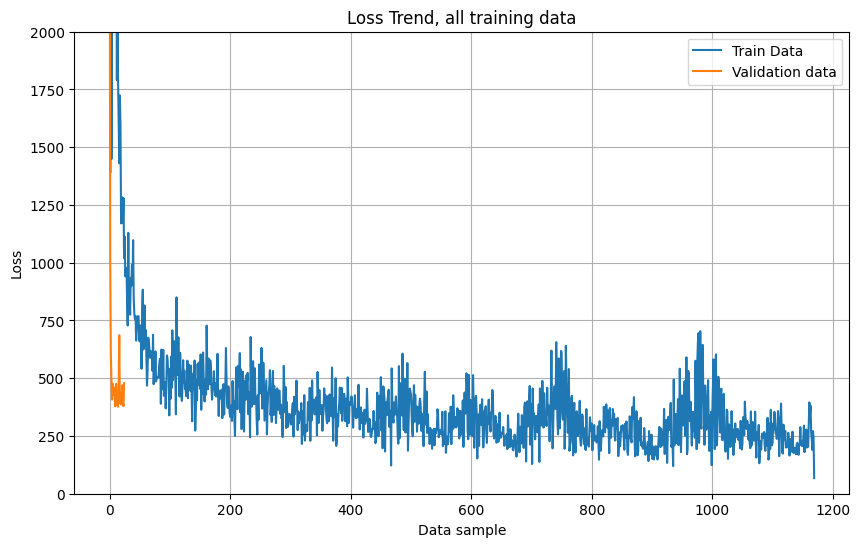

In [872]:
window_size = 10
moving_avg = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
indices = np.arange(window_size//2, len(train_losses) - window_size//2 + 1)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Data')
# plt.plot(indices, moving_avg, color='red', label=f'Moving Average (Window Size = {window_size})')
plt.plot(val_losses, label='Validation data')
plt.xlabel('Data sample')
plt.ylabel('Loss')
plt.title('Loss Trend with Moving Average, LR=0.001')

plt.xlabel('Data sample')
plt.ylabel('Loss')
plt.ylim(0, 2000)
plt.title('Loss Trend, all training data')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = DenseNet(num_channels=3)

model2.to(device)

criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

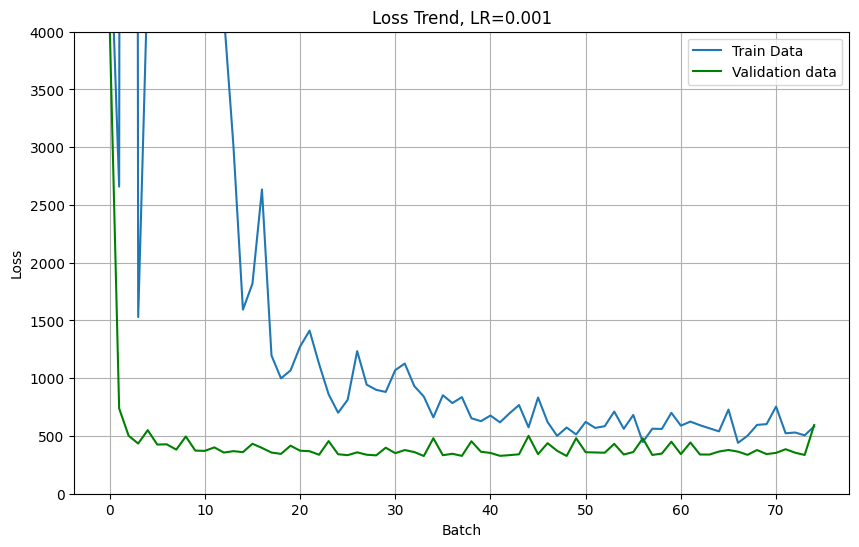

In [337]:
# Loss trend plots
# Skulle kunna köra en träning med mer valideringsdata.

losses = []
validation = []
with open ("train_ALL.txt", 'r') as f:
    for line in f: 
        losses.append(float(line))
        

with open("val_ALL.txt", "r") as f2:
    for line2 in f2:
        validation.append(float(line2))
        

# print(len(train_losses))
# print(len(val_losses))
# window_size = 10
# Calculate the moving average using np.convolve
# moving_avg = np.convolve(losses[0:50], np.ones(window_size)/window_size, mode='valid')

# Calculate the indices for plotting
# indices = np.arange(window_size//2, len(losses) - window_size//2 + 1)
# print(len(indices))

# Plot the original data and the smoothed data
plt.figure(figsize=(10, 6))
# plt.plot(training_loss[0:75], label='Original Data')
plt.plot(losses[0:75], label='Train Data')
# plt.plot(indices, moving_avg, color='red', label=f'Moving Average (Window Size = {window_size})')
plt.plot(validation, label= "Validation data", color="g")
# plt.xticks(range(0, 50, 5))
# plt.yticks(range(0, 12500, 1000))
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.ylim(0, 4000)
plt.title('Loss Trend, LR=0.001')
plt.legend()
plt.grid(True)
plt.show()
        

In [338]:
def test_model(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []
    image_paths = []
    with torch.no_grad():
        for data in dataloader:              
            inputs, labels, img_paths = data      # inputs are tensorized images
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy()) 
            true_labels.extend(labels.cpu().numpy())
            image_paths.extend(img_paths)

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    image_paths = np.array(image_paths)

    return predictions, true_labels, image_paths

In [339]:
predictions, true_labels, image_paths = test_model(model, test_loader)
test_df = pd.DataFrame({'Image_Path': image_paths, 'Ground_Truth': true_labels, 'Inference': predictions}) # plocka ut bara komp_nivå, film och crop

In [373]:
centers = test_df[test_df["Image_Path"].str.contains("center")]
corners = test_df[(test_df["Image_Path"].str.contains("bottom") | test_df["Image_Path"].str.contains("top")) & (test_df["Image_Path"].str.contains("left") | test_df["Image_Path"].str.contains("right"))]
edges = test_df[(test_df["Image_Path"].str.contains("bottom") | test_df["Image_Path"].str.contains("top") | test_df["Image_Path"].str.contains("right") | test_df["Image_Path"].str.contains("left"))] 

test_df['Position'] = 'Other'   # alla positioner som inte tillhör kategorierna ovan
test_df.loc[test_df.index.isin(edges.index), 'Position'] = 'Edge'
test_df.loc[test_df.index.isin(corners.index), 'Position'] = 'Corner'
test_df.loc[test_df.index.isin(centers.index), 'Position'] = 'Center'

test_df['Compression_Level'] = test_df['Image_Path'].apply(lambda x: x.split('_')[8].split('_frame')[0])
test_df['Movie_Name'] = test_df['Image_Path'].apply(lambda x: x.split('_')[9].split('_frame')[0])

print(test_df)

test_df.to_csv('inference_ALL.csv', index=False)
# result = test_df[test_df['Position'] == "Edge"]
# print(result)

                                              Image_Path  Ground_Truth  \
0      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427361   
1      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427361   
2      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427361   
3      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427361   
4      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427361   
...                                                  ...           ...   
17755  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      9.618851   
17756  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     31.796865   
17757  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      7.720450   
17758  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      3.858760   
17759  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     23.807552   

        Inference Position Compression_Level                  Movie_Name  
0      106.869057   Corner          

In [341]:
test_df.to_pickle("inference.pkl")       # pickle file

In [374]:
# Double-checking that the ground truths values are correct.

csv_file_path = "inference_ALL.csv"
csv_file_path2 = "vmaf_values_TEST_ALL.csv"
vmaf_from_inference= []
vmaf_from_gt = []

with open(csv_file_path, newline='') as csvfile:
    csvfile.readline()
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        vmaf_score = float(row[1])
        vmaf_from_inference.append(vmaf_score)
        
vmaf_scores2 = []
with open(csv_file_path2, newline='') as csvfile:
    csvfile.readline()
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        vmaf_score = float(row[0])
        vmaf_from_gt.append(vmaf_score)
        
print(vmaf_from_inference[0])      
print(vmaf_from_gt[0])

print(vmaf_from_inference[1])      
print(vmaf_from_gt[1])

print(vmaf_from_inference[100])      
print(vmaf_from_gt[100])

print(vmaf_from_inference[1200])      
print(vmaf_from_gt[1200])

print(vmaf_from_inference[5000])      
print(vmaf_from_gt[5000])

97.42736
97.427361
97.42736
97.427361
71.35604
71.35604
84.19123
84.191232
91.13322
91.133216


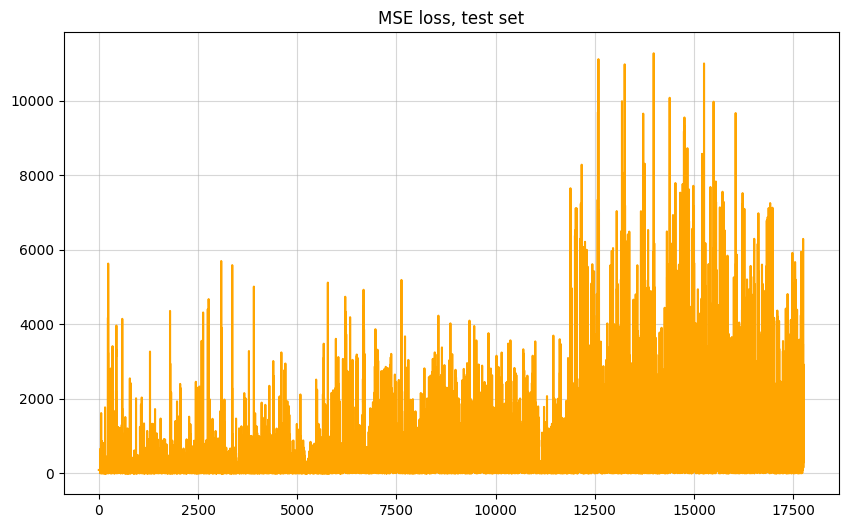

In [345]:
# den här grafen säger inte så mycket om modellens prestanda
df = pd.read_csv("inference_ALL.csv")
ground_truths = df["Ground_Truth"]
predictions = df["Inference"]

mse_values = []
for true, pred in zip(ground_truths, predictions):
    mse = mean_squared_error([true], [pred])  
    mse_values.append(mse)

df['MSE'] = mse_values

plt.figure(figsize=(10, 6))
plt.plot
plt.plot(df['MSE'], color="orange", label="All test data")
plt.title("MSE loss, test set")
plt.grid(alpha=0.5)

In [375]:
r_squared_values = []
ground_truths = df["Ground_Truth"]
predictions = df["Inference"]

r_squared = r2_score(ground_truths, predictions)

print("R-squared score on the entire test set:", r_squared)

std_dev = np.std(ground_truths - predictions)
print("Standard deviation of the entire test set", std_dev)


R-squared score on the entire test set: 0.3659824490034673
Standard deviation of the entire test set 20.400454944023533


In [377]:
corners = test_df.loc[test_df['Position'] == 'Corner']
corners_compression_23 = corners.loc[corners['Compression_Level'] == '23']
print(corners['Compression_Level'])

0        23
1        23
2        23
3        23
12       23
         ..
17731    51
17740    51
17741    51
17742    51
17743    51
Name: Compression_Level, Length: 4440, dtype: object


In [378]:
corners = test_df.loc[test_df['Position'] == 'Corner']
corners_compression_23 = corners.loc[corners['Compression_Level'] == '23']
corners_compression_37 = corners.loc[corners['Compression_Level'] == '37']
corners_compression_51 = corners.loc[corners['Compression_Level'] == '51']

centers = test_df.loc[test_df['Position'] == 'Center']
centers_compression_23 = centers.loc[centers['Compression_Level'] == '23']
centers_compression_37 = centers.loc[centers['Compression_Level'] == '37']
centers_compression_51 = centers.loc[centers['Compression_Level'] == '51']

edges = test_df.loc[test_df['Position'] == 'Edge']
edges_compression_23 = edges.loc[edges['Compression_Level'] == '23']
edges_compression_37 = edges.loc[edges['Compression_Level'] == '37']
edges_compression_51 = edges.loc[edges['Compression_Level'] == '51']
    

In [388]:
print(len(corners_compression_23))
print(len(corners_compression_37))
print(len(corners_compression_51))

print()
print(len(centers_compression_23))
print(len(centers_compression_37))
print(len(centers_compression_51))

print()
print(len(edges_compression_23))
print(len(edges_compression_37))
print(len(edges_compression_51))

1480
1480
1480

185
185
185

4255
4255
4255


In [390]:
def abs_diff(gt, pred):      
    diff = gt - pred
    return abs(diff)        

abs_diffs_corners_23 = []
for true, pred in zip(corners_compression_23['Ground_Truth'], corners_compression_23['Inference']): 
    abs_diffs_corners_23.append(abs_diff(true, pred))

std_corners_23 = np.std(corners_compression_23['Inference'])
    
abs_diffs_corners_37 = []
for true, pred in zip(corners_compression_37['Ground_Truth'], corners_compression_37['Inference']): 
    abs_diffs_corners_37.append(abs_diff(true, pred))

std_corners_37 = np.std(corners_compression_37['Inference'])
    
abs_diffs_corners_51 = []
for true, pred in zip(corners_compression_51['Ground_Truth'], corners_compression_51['Inference']): 
    abs_diffs_corners_51.append(abs_diff(true, pred))

std_corners_51 = np.std(corners_compression_51['Inference'])

abs_diffs_centers_23 = []
for true, pred in zip(centers_compression_23['Ground_Truth'], centers_compression_23['Inference']): 
    abs_diffs_centers_23.append(abs_diff(true, pred))

std_centers_23 = np.std(centers_compression_23['Inference'])
    
abs_diffs_centers_37 = []
for true, pred in zip(centers_compression_37['Ground_Truth'], centers_compression_37['Inference']): 
    abs_diffs_centers_37.append(abs_diff(true, pred))

std_centers_37 = np.std(centers_compression_37['Inference'])
    
abs_diffs_centers_51 = []
for true, pred in zip(centers_compression_51['Ground_Truth'], centers_compression_51['Inference']): 
    abs_diffs_centers_51.append(abs_diff(true, pred))

std_centers_51 = np.std(centers_compression_51['Inference'])
    
abs_diffs_edges_23 = []
for true, pred in zip(edges_compression_23['Ground_Truth'], edges_compression_23['Inference']): 
    abs_diffs_edges_23.append(abs_diff(true, pred))

std_edges_23 = np.std(edges_compression_23['Inference'])
    
abs_diffs_edges_37 = []
for true, pred in zip(edges_compression_37['Ground_Truth'], edges_compression_37['Inference']): 
    abs_diffs_edges_37.append(abs_diff(true, pred))

std_edges_37 = np.std(edges_compression_37['Inference'])
    
abs_diffs_edges_51 = []
for true, pred in zip(edges_compression_51['Ground_Truth'], edges_compression_51['Inference']): 
    abs_diffs_edges_51.append(abs_diff(true, pred))

std_edges_51 = np.std(edges_compression_51['Inference'])
   
    
print(sum(abs_diffs_corners_23)/ len(abs_diffs_corners_23))
print(std_corners_23)



11.165807387635514
15.357018


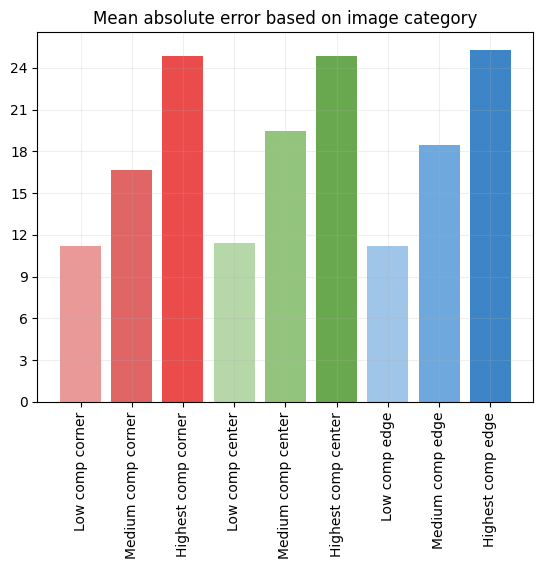

In [391]:
categories = ["Low comp corner", "Medium comp corner", "Highest comp corner", "Low comp center", "Medium comp center", "Highest comp center", "Low comp edge", "Medium comp edge", "Highest comp edge"]
avg_diffs = [sum(abs_diffs_corners_23)/len(abs_diffs_corners_23), sum(abs_diffs_corners_37)/len(abs_diffs_corners_37), sum(abs_diffs_corners_51)/len(abs_diffs_corners_51), sum(abs_diffs_centers_23)/len(abs_diffs_centers_23), sum(abs_diffs_centers_37)/len(abs_diffs_centers_37), sum(abs_diffs_centers_51) / len(abs_diffs_centers_51), sum(abs_diffs_edges_23)/ len(abs_diffs_edges_23), sum(abs_diffs_edges_37)/len(abs_diffs_edges_37), sum(abs_diffs_edges_51)/len(abs_diffs_edges_51)]
colors = ["#ea9999", "#e06666", "#ea4c4c", "#b6d7a8", "#93c47d", "#6aa84f", "#9fc5e8", "#6fa8dc", "#3d85c6"]

plt.bar(categories, avg_diffs, color = colors)
plt.xticks(rotation='vertical')
plt.yticks(range(0, 25, 3))
plt.title("Mean absolute error based on image category")
plt.grid(alpha=0.2)


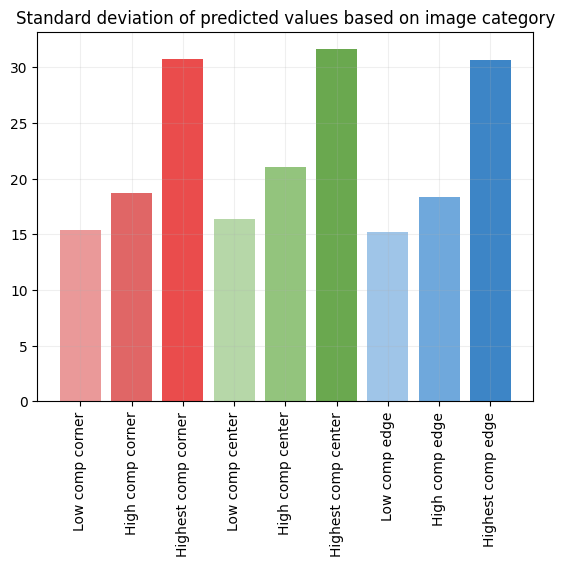

In [392]:
categories = ["Low comp corner", "High comp corner", "Highest comp corner", "Low comp center", "High comp center", "Highest comp center", "Low comp edge", "High comp edge", "Highest comp edge"]
stds = [std_corners_23, std_corners_37, std_corners_51, std_centers_23, std_centers_37, std_centers_51, std_edges_23, std_edges_37, std_edges_51]
colors = ["#ea9999", "#e06666", "#ea4c4c", "#b6d7a8", "#93c47d", "#6aa84f", "#9fc5e8", "#6fa8dc", "#3d85c6"]

plt.bar(categories, stds, color = colors)
plt.xticks(rotation='vertical')
plt.title("Standard deviation of predicted values based on image category")
plt.grid(alpha=0.2)

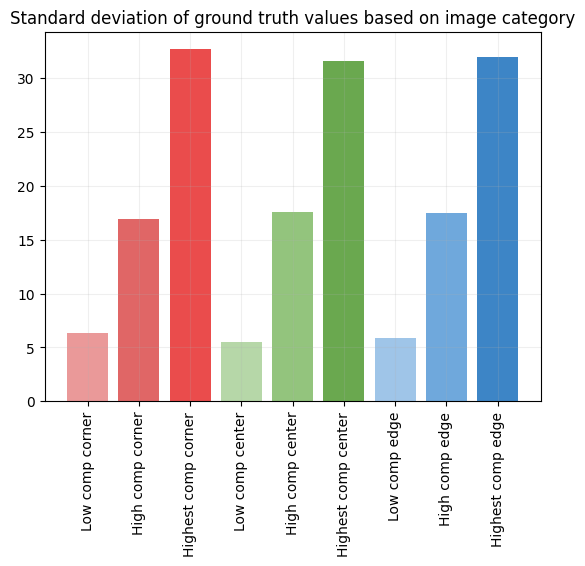

In [393]:
categories = ["Low comp corner", "High comp corner", "Highest comp corner", "Low comp center", "High comp center", "Highest comp center", "Low comp edge", "High comp edge", "Highest comp edge"]
stds_true = [np.std(corners_compression_23['Ground_Truth']), np.std(corners_compression_37['Ground_Truth']), np.std(corners_compression_51['Ground_Truth']), np.std(centers_compression_23['Ground_Truth']), np.std(centers_compression_37['Ground_Truth']), np.std(centers_compression_51['Ground_Truth']), np.std(edges_compression_23['Ground_Truth']), np.std(edges_compression_37['Ground_Truth']), np.std(edges_compression_51['Ground_Truth'])]
colors = ["#ea9999", "#e06666", "#ea4c4c", "#b6d7a8", "#93c47d", "#6aa84f", "#9fc5e8", "#6fa8dc", "#3d85c6"]

plt.bar(categories, stds_true, color = colors)
plt.xticks(rotation='vertical')
plt.title("Standard deviation of ground truth values based on image category")
plt.grid(alpha=0.2)

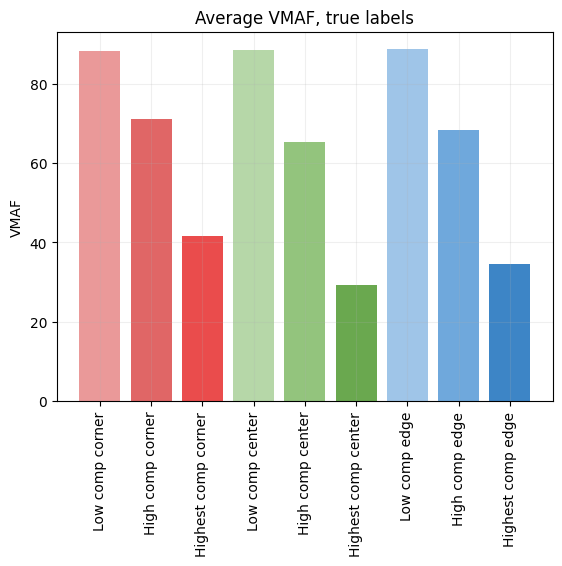

In [395]:
categories = ["Low comp corner", "High comp corner", "Highest comp corner", "Low comp center", "High comp center", "Highest comp center", "Low comp edge", "High comp edge", "Highest comp edge"]
avg_vmaf_true = [sum(corners_compression_23['Ground_Truth'])/len(corners_compression_23['Ground_Truth']), sum(corners_compression_37['Ground_Truth'])/ len(corners_compression_37['Ground_Truth']), sum(corners_compression_51['Ground_Truth'])/len(corners_compression_51['Ground_Truth']), sum(centers_compression_23['Ground_Truth'])/len(centers_compression_23['Ground_Truth']), sum(centers_compression_37['Ground_Truth'])/len(centers_compression_37['Ground_Truth']), sum(centers_compression_51['Ground_Truth'])/len(centers_compression_51['Ground_Truth']), sum(edges_compression_23['Ground_Truth'])/len(edges_compression_23['Ground_Truth']), sum(edges_compression_37['Ground_Truth'])/len(edges_compression_37['Ground_Truth']), sum(edges_compression_51['Ground_Truth'])/len(edges_compression_51['Ground_Truth'])]
avg_vmaf_pred = [sum(corners_compression_23['Inference'])/len(corners_compression_23['Inference']), sum(corners_compression_37['Inference'])/ len(corners_compression_37['Inference']), sum(corners_compression_51['Inference'])/len(corners_compression_51['Inference']), sum(centers_compression_23['Inference'])/len(centers_compression_23['Inference']), sum(centers_compression_37['Inference'])/len(centers_compression_37['Inference']), sum(centers_compression_51['Inference'])/len(centers_compression_51['Inference']), sum(edges_compression_23['Inference'])/len(edges_compression_23['Inference']), sum(edges_compression_37['Inference'])/len(edges_compression_37['Inference']), sum(edges_compression_51['Inference'])/len(edges_compression_51['Inference'])]
colors = ["#ea9999", "#e06666", "#ea4c4c", "#b6d7a8", "#93c47d", "#6aa84f", "#9fc5e8", "#6fa8dc", "#3d85c6"]

plt.bar(categories, avg_vmaf_true, color = colors)
plt.title("Average VMAF, true labels")
plt.ylabel('VMAF')
plt.xticks(rotation='vertical')
plt.grid(alpha=0.2)


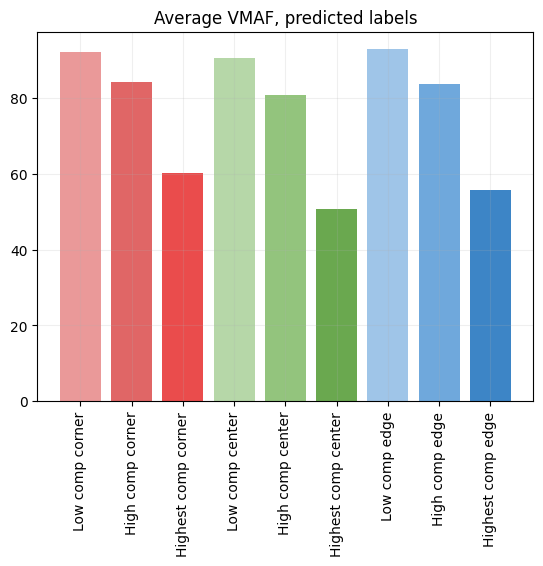

In [396]:
plt.bar(categories, avg_vmaf_pred, color = colors)
plt.title("Average VMAF, predicted labels")
plt.xticks(rotation='vertical')
plt.grid(alpha=0.2)

MAE loss based on movie name is 18.410325611338894
R^2 score of model performance, sorted by movie is 0.36598245580613453


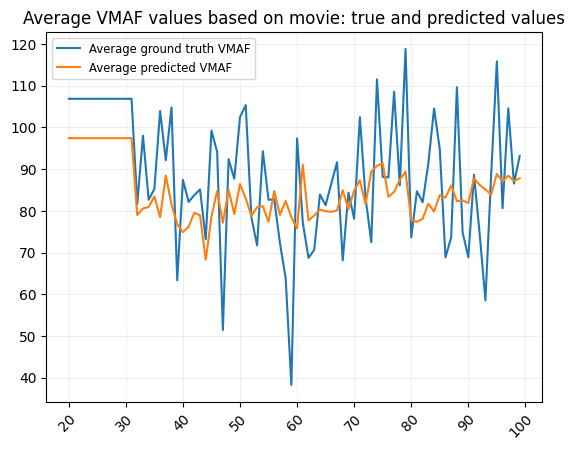

In [427]:
abs_diffs_movies = []

average_ground_truth = test_df.groupby(['Movie_Name'])['Ground_Truth'].mean().reset_index()
average_vmaf_pred = test_df.groupby(['Movie_Name'])['Inference'].mean().reset_index()

abs_diffs_movies = []
for movie in test_df['Movie_Name'].unique():
    abs_diff = abs(test_df.loc[test_df['Movie_Name'] == movie, 'Ground_Truth'] - test_df.loc[test_df['Movie_Name'] == movie, 'Inference'])
    abs_diffs_movies.append(abs_diff.mean())
    
print("MAE loss based on movie name is", sum(abs_diffs_movies)/len(abs_diffs_movies))

r_squared = r2_score(test_df['Ground_Truth'], test_df['Inference'])
print("R^2 score of model performance, sorted by movie is", r_squared)

plt.plot(test_df['Inference'][20:100], label="Average ground truth VMAF")
plt.plot(test_df['Ground_Truth'][20:100], label="Average predicted VMAF")
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')  
plt.legend(fontsize='small')
plt.title('Average VMAF values based on movie: true and predicted values')
plt.grid(alpha=0.2)
plt.show()
    

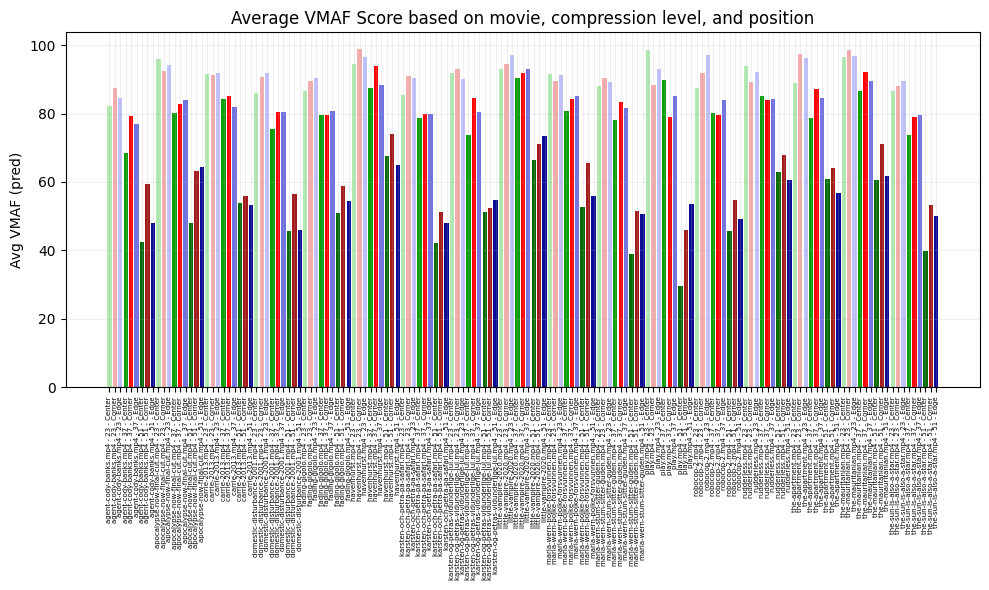

In [529]:
# filtered_df = test_df[test_df['Movie_Name'] == 'agent-cody-banks.mp4']

# filtered_df = test_df[test_df['Movie_Name']]

# Group by Movie_Name, Compression_Level, and Position and calculate average Inference value
grouped_df = test_df.groupby(['Movie_Name', 'Compression_Level', 'Position'])['Inference'].mean().reset_index()

# Define categories for x-axis labels
categories = [f"{movie} - {compression} - {position}" for movie, compression, position in zip(grouped_df['Movie_Name'], grouped_df['Compression_Level'].replace('75', '51'), grouped_df['Position'])]
colors = []
for cat in categories:
    if "Corner" in cat:
        if "23" in cat:
            colors.append("#f5adad")
            
        elif "37" in cat:
            colors.append("#ff0000")
            
        elif "51" in cat:
            colors.append("#a41919")
            
    elif "Center" in cat:
        if "23" in cat:
            colors.append("#b2ebb2")
            
        elif "37" in cat:
            colors.append("#099f09")
            
        elif "51" in cat:
            colors.append("#056c05")
          
    elif "Edge" in cat:
        if "23" in cat:
            colors.append("#c2c2fe")
            
        elif "37" in cat:
            colors.append("#7171e2")
            
        elif "51" in cat:
            colors.append("#0b0b95")  
    
            
# print(colors)

plt.figure(figsize=(10, 6))
plt.bar(categories, grouped_df['Inference'], color=colors)
plt.title('Average VMAF Score based on movie, compression level, and position')
plt.ylabel('Avg VMAF (pred)')
plt.xticks(rotation=90, fontsize=5)
# plt.ylim(0, 100)
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()

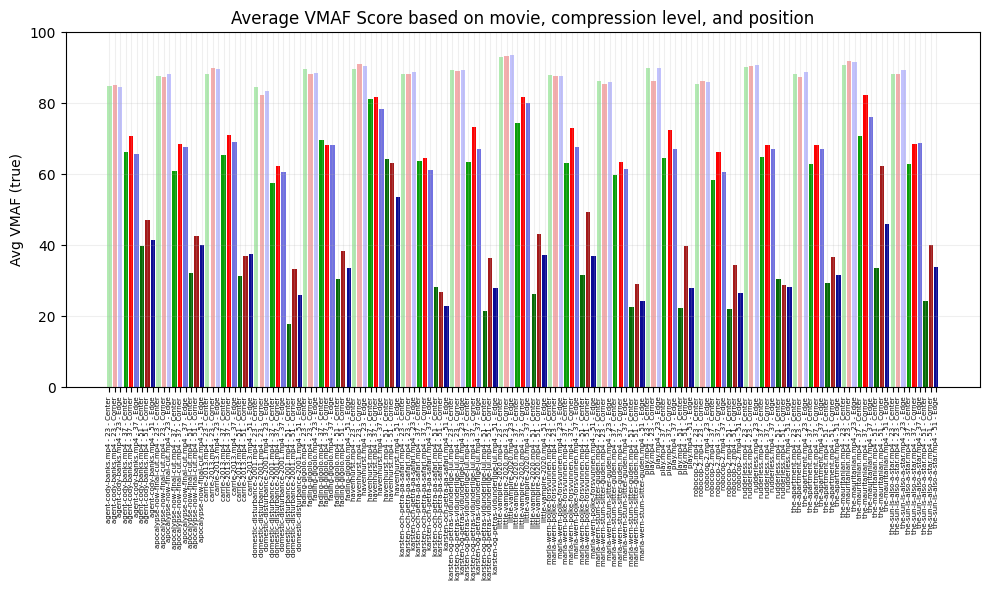

In [533]:
grouped_df = test_df.groupby(['Movie_Name', 'Compression_Level', 'Position'])['Ground_Truth'].mean().reset_index()

# Define categories for x-axis labels
categories = [f"{movie} - {compression} - {position}" for movie, compression, position in zip(grouped_df['Movie_Name'], grouped_df['Compression_Level'], grouped_df['Position'])]

def colors(categories):
    colors = []
    for cat in categories:
        if "Corner" in cat:
            if "23" in cat:
                colors.append("#f5adad")
                
            elif "37" in cat:
                colors.append("#ff0000")
                
            elif "51" in cat:
                colors.append("#a41919")
                
        elif "Center" in cat:
            if "23" in cat:
                colors.append("#b2ebb2")
                
            elif "37" in cat:
                colors.append("#099f09")
                
            elif "51" in cat:
                colors.append("#056c05")
            
        elif "Edge" in cat:
            if "23" in cat:
                colors.append("#c2c2fe")
                
            elif "37" in cat:
                colors.append("#7171e2")
                
            elif "51" in cat:
                colors.append("#0b0b95")  
        
    return colors

plt.figure(figsize=(10, 6))
plt.bar(categories, grouped_df['Ground_Truth'], color=colors(categories))
plt.title('Average VMAF Score based on movie, compression level, and position')
plt.ylabel('Avg VMAF (true)')
plt.xticks(rotation=90, fontsize=5)
plt.ylim(0, 100)
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()

In [447]:
print(min(round(grouped_df['Ground_Truth'])))
print(min(np.ceil(grouped_df['Ground_Truth'])))
print(min(grouped_df['Ground_Truth']))

18.0
18.0
17.817148208618164


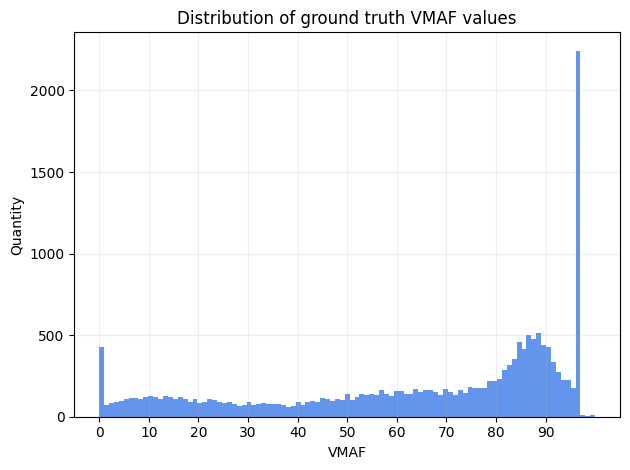

In [448]:
plt.hist(round(test_df['Ground_Truth']), bins=int(max(round(test_df['Ground_Truth']))) - int(min(round(test_df['Ground_Truth']))) + 1, color='cornflowerblue')
plt.title('Distribution of ground truth VMAF values')
plt.ylabel('Quantity')
plt.xticks(range(0, 100, 10))
plt.xlabel('VMAF')
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()

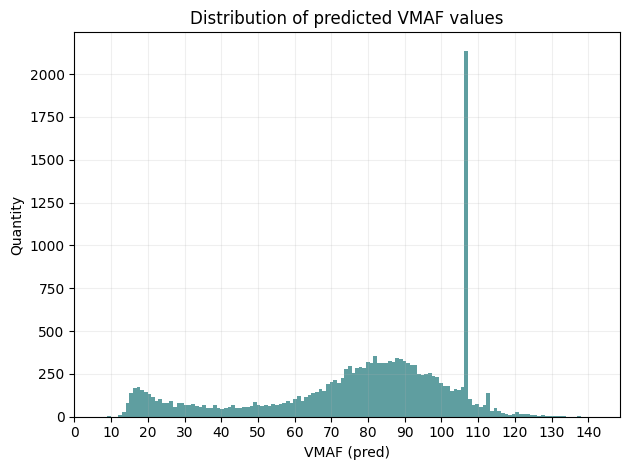

In [449]:
plt.hist(round(test_df['Inference']), bins=int(max(round(test_df['Inference']))) - int(min(round(test_df['Inference']))) + 1, color='cadetblue')
plt.title('Distribution of predicted VMAF values')
plt.ylabel('Quantity')
plt.xticks(range(0, int(max(round(test_df['Inference']))), 10))
plt.xlabel('VMAF (pred)')
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()

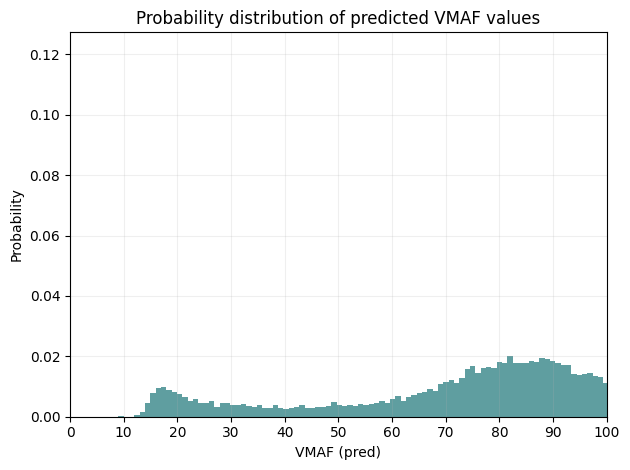

In [451]:
plt.hist(round(test_df['Inference']), bins=int(max(round(test_df['Inference']))) - int(min(round(test_df['Inference']))) + 1, color='cadetblue', density=True)
plt.title('Probability distribution of predicted VMAF values')
plt.ylabel('Probability')
plt.xticks(range(0, 105, 10))
plt.xlim([0, 100])
plt.xlabel('VMAF (pred)')
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()

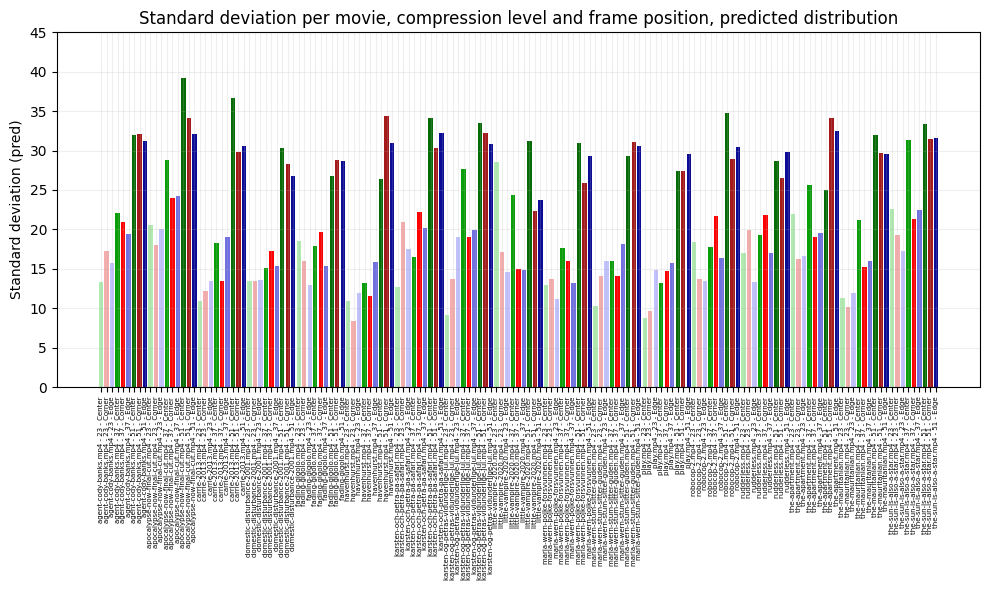

In [514]:
grouped_df = test_df.groupby(['Movie_Name', 'Compression_Level', 'Position'])['Inference'].std().reset_index()
categories = [f"{movie} - {compression} - {position}" for movie, compression, position in zip(grouped_df['Movie_Name'], grouped_df['Compression_Level'], grouped_df['Position'])]
plt.figure(figsize=(10, 6))
plt.bar(categories, grouped_df['Inference'], color=colors(categories))
plt.title('Standard deviation per movie, compression level and frame position, predicted distribution')
plt.ylabel('Standard deviation (pred)')
plt.xticks(rotation=90, fontsize=5)
plt.ylim(0, 45)
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()

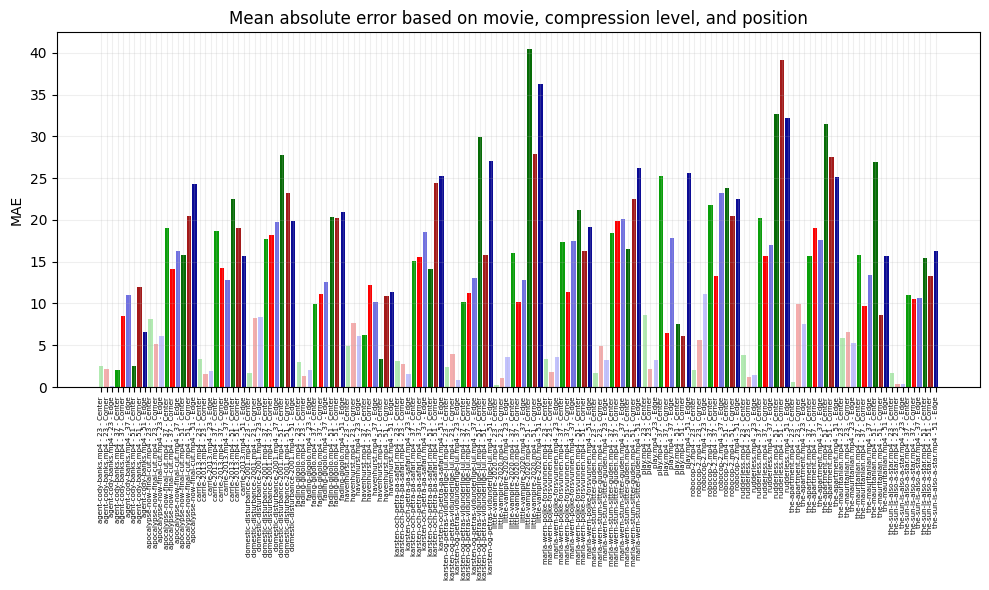

In [515]:
grouped_df1 = test_df.groupby(['Movie_Name', 'Compression_Level', 'Position'])['Inference'].mean().reset_index()
grouped_df2 = test_df.groupby(['Movie_Name', 'Compression_Level', 'Position'])['Ground_Truth'].mean().reset_index()

mae = mean_absolute_error([grouped_df2['Ground_Truth']],[grouped_df1['Inference']], multioutput='raw_values')

# print(mae)

plt.figure(figsize=(10, 6))
plt.bar(categories, mae, color=colors(categories))
plt.title('Mean absolute error based on movie, compression level, and position')
plt.ylabel('MAE')
plt.xticks(rotation=90, fontsize=5)
# plt.ylim(0, 30)
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()

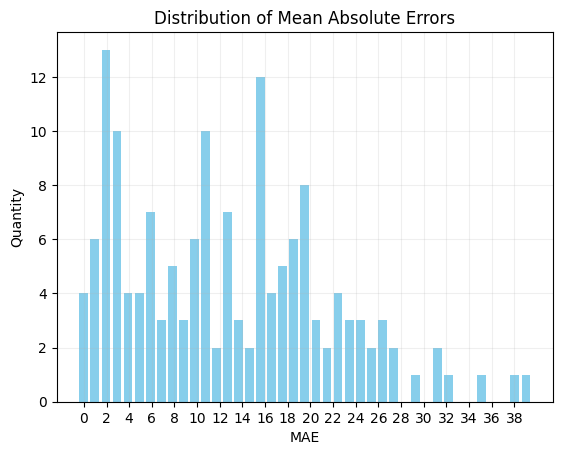

In [516]:
# print(mae)

rounded_mae = []
for e in mae:
    rounded_mae.append(round(e))
    
# print(rounded_mae)

plt.hist(rounded_mae, bins=max(rounded_mae)-min(rounded_mae)+1, align='left', rwidth=0.8, color='skyblue')
plt.xticks(range(0, max(rounded_mae), 2))

plt.xlabel('MAE')
plt.ylabel('Quantity')
plt.grid(alpha=0.2)
plt.title('Distribution of Mean Absolute Errors')

plt.show()

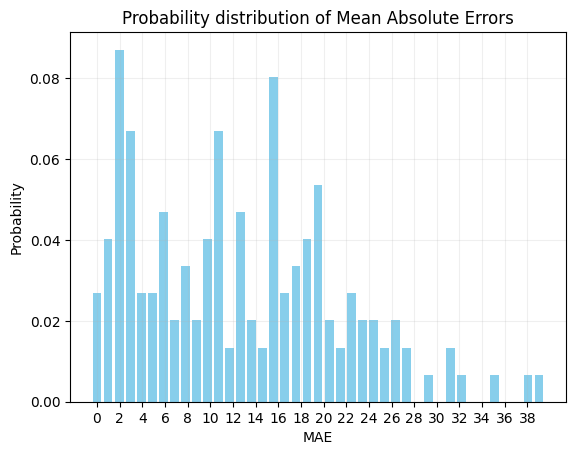

In [517]:
plt.hist(rounded_mae, bins=max(rounded_mae)-min(rounded_mae)+1, align='left', rwidth=0.8, color='skyblue', density=True)
plt.xticks(range(0, max(rounded_mae), 2))

plt.xlabel('MAE')
plt.ylabel('Probability')
plt.grid(alpha=0.2)
plt.title('Probability distribution of Mean Absolute Errors')

plt.show()

In [530]:
mae2 = mean_absolute_error([round(grouped_df1['Inference'])], [round(grouped_df2['Ground_Truth'])], multioutput='raw_values')
print(mae2)

[ 3.  2.  0.  2.  8. 11.  2. 12.  7.  8.  5.  6. 19. 14. 16. 16. 20. 24.
  4.  1.  2. 19. 14. 13. 23. 19. 15.  1.  9.  8. 17. 19. 19. 28. 23. 20.
  3.  2.  3. 10. 12. 13. 21. 21. 21.  5.  8.  7.  6. 12. 10.  4. 11. 11.
  3.  3.  2. 15. 16. 19. 14. 24. 25.  2.  4.  1. 11. 12. 13. 30. 16. 27.
  0.  1.  3. 16. 10. 13. 41. 28. 37.  3.  2.  3. 18. 11. 17. 22. 17. 19.
  2.  4.  3. 18. 19. 21. 17. 23. 26.  9.  2.  3. 26.  7. 18.  8.  6. 25.
  3.  6. 11. 22. 14. 23. 24. 21. 22.  4.  1.  1. 20. 16. 17. 33. 39. 32.
  1. 10.  7. 16. 19. 18. 32. 27. 25.  6.  7.  5. 16. 10. 14. 27.  9. 16.
  1.  0.  1. 11. 11. 10. 16. 13. 16.]


In [545]:
print(len(grouped_df1))
print(len(test_df))

153
17760


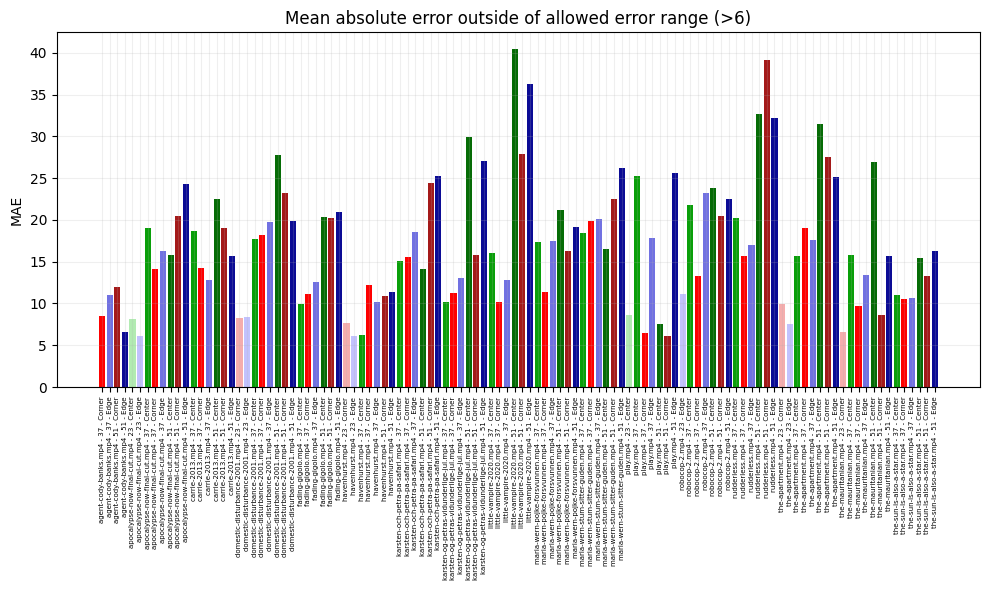

In [548]:
indices = []

grouped_df1 = test_df.groupby(['Movie_Name', 'Compression_Level', 'Position'])['Inference'].mean().reset_index()
grouped_df2 = test_df.groupby(['Movie_Name', 'Compression_Level', 'Position'])['Ground_Truth'].mean().reset_index()

mae = mean_absolute_error([grouped_df2['Ground_Truth']],[grouped_df1['Inference']], multioutput='raw_values')
# mae = mean_absolute_error([test_df['Ground_Truth']],[test_df['Inference']], multioutput='raw_values')

for i in range(len(grouped_df1['Inference'])):
    if mae[i] > 6:
        indices.append(i)
        
categories = [f"{movie} - {compression} - {position}" for movie, compression, position in zip(grouped_df1['Movie_Name'][[i for i in indices]], grouped_df1['Compression_Level'][[i for i in indices]], grouped_df1['Position'][[i for i in indices]])]


# print(indices)

# print(mae[[i for i in indices]])

plt.figure(figsize=(10, 6))
plt.bar(categories, mae[[i for i in indices]], color=colors(categories))
plt.title('Mean absolute error outside of allowed error range (>6)')
plt.ylabel('MAE')
plt.xticks(rotation=90, fontsize=5)
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()


[0, 1, 2, 3, 6, 10, 18, 19, 20, 27, 36, 37, 38, 45, 51, 54, 55, 56, 63, 64, 65, 72, 73, 74, 81, 82, 83, 90, 91, 92, 100, 101, 108, 109, 117, 118, 119, 126, 135, 137, 144, 145, 146]


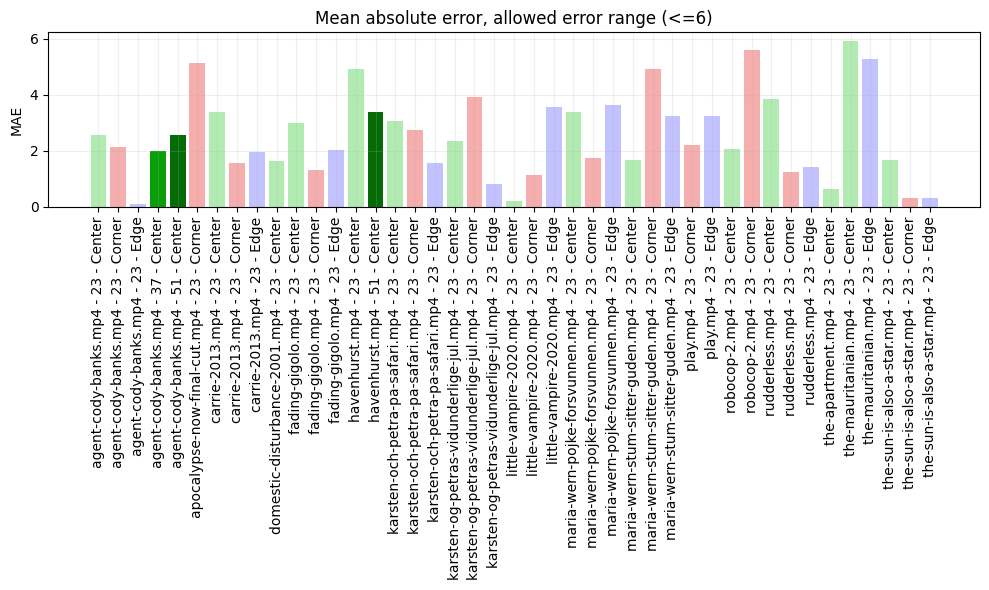

In [549]:
indices = []

for i in range(len(grouped_df1['Inference'])):
    if mae[i] <= 6:
        indices.append(i)
        
categories = [f"{movie} - {compression} - {position}" for movie, compression, position in zip(grouped_df1['Movie_Name'][[i for i in indices]], grouped_df1['Compression_Level'].replace('75', '51')[[i for i in indices]], grouped_df1['Position'][[i for i in indices]])]


print(indices)


plt.figure(figsize=(10, 6))
plt.bar(categories, mae[[i for i in indices]], color=colors(categories))
plt.title('Mean absolute error, allowed error range (<=6)')
plt.ylabel('MAE')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()

In [9]:
test_df = pd.read_csv('inference.csv')

In [551]:
mae = mean_absolute_error([test_df['Ground_Truth']], [test_df['Inference']], multioutput='raw_values')
print("Average error, sorted by movie, compression level and frame location is", mae.mean())
r_squared = r2_score(test_df['Ground_Truth'], test_df['Inference'])
print("R^2 score of model performance, sorted by movie, compression level and frame location is", r_squared)

Average error, sorted by movie, compression level and frame location is 18.13255
R^2 score of model performance, sorted by movie, compression level and frame location is 0.36598245580613453


In [550]:
mae = mean_absolute_error([grouped_df2['Ground_Truth']], [grouped_df1['Inference']], multioutput='raw_values')
print("Average error, sorted by movie, compression level and frame location is", mae.mean())
r_squared = r2_score(grouped_df2['Ground_Truth'], grouped_df1['Inference'])
print("R^2 score of model performance, sorted by movie, compression level and frame location is", r_squared)

Average error, sorted by movie, compression level and frame location is 12.98968
R^2 score of model performance, sorted by movie, compression level and frame location is 0.5349443333243578


In [10]:
grouped_df1 = test_df.groupby(['Movie_Name', 'Compression_Level', 'Position'])['Inference'].mean().reset_index()
grouped_df2 = test_df.groupby(['Movie_Name', 'Compression_Level', 'Position'])['Ground_Truth'].mean().reset_index()

print(len(grouped_df2['Ground_Truth'].to_numpy()))

51


In [552]:
print(len(grouped_df2['Ground_Truth'].to_numpy()))
print(len(grouped_df))

print(sorted(grouped_df2['Ground_Truth'].to_numpy()))

colors = sorted(grouped_df2['Ground_Truth'].to_numpy())

153
153
[17.817148, 21.390034, 21.924904, 22.168756, 22.430717, 22.70746, 24.314905, 24.363604, 26.038843, 26.087608, 26.595194, 26.822392, 27.786842, 27.800741, 28.081678, 28.241196, 28.708206, 29.066113, 29.214828, 30.318892, 30.399055, 31.400305, 31.471338, 31.55802, 32.27748, 33.190716, 33.454887, 33.633038, 33.816364, 34.3731, 36.4466, 36.631783, 36.802002, 36.82631, 37.217705, 37.56042, 38.481724, 39.864655, 39.87785, 40.05295, 40.164795, 41.43594, 42.603016, 43.213665, 46.07214, 47.224022, 49.33998, 53.665134, 57.655376, 58.422424, 59.656322, 60.597195, 60.680473, 61.00853, 61.21733, 61.384247, 62.358227, 62.432934, 62.7589, 62.963417, 63.08958, 63.284485, 63.405415, 63.569904, 63.673428, 64.345215, 64.43221, 64.44714, 64.93179, 65.49, 65.78663, 66.27807, 66.37963, 66.99676, 67.19584, 67.203865, 67.21078, 67.571754, 67.74501, 68.12112, 68.252754, 68.31642, 68.32949, 68.38896, 68.58695, 68.84451, 68.97359, 69.566154, 70.71374, 70.87055, 70.964554, 72.4976, 72.92729, 73.188484, 74

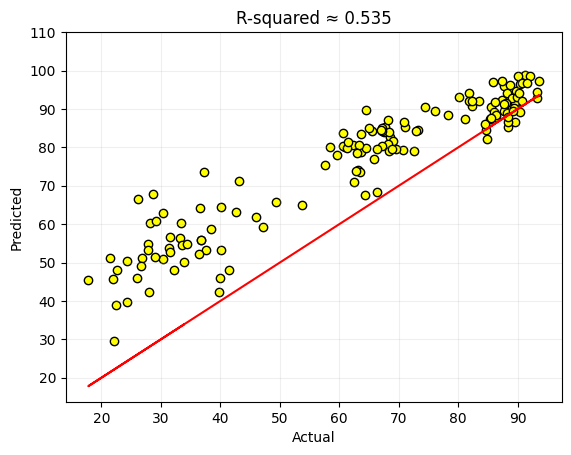

In [553]:
fig, ax = plt.subplots()
# ax.scatter(grouped_df2['Ground_Truth'].to_numpy(), grouped_df1['Inference'].to_numpy(), c='blue')
ax.scatter(grouped_df2['Ground_Truth'].to_numpy(), grouped_df1['Inference'].to_numpy(), c='yellow', edgecolors= "black")

# m, b = np.polyfit(sorted(grouped_df2['Ground_Truth'].to_numpy()), sorted(grouped_df1['Inference'].to_numpy()), 1)
m, b = np.polyfit(sorted(grouped_df2['Ground_Truth'].to_numpy()), sorted(grouped_df2['Ground_Truth'].to_numpy()), 1)

# adding the regression line to the scatter plot
plt.plot(grouped_df2['Ground_Truth'].to_numpy(), m*grouped_df2['Ground_Truth'].to_numpy() + b, color='r')
# ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
ax.grid(alpha=0.2)
plt.yticks(range(20, 120, 10))
y_test, y_predicted = grouped_df2['Ground_Truth'].to_numpy().reshape(-1,1), grouped_df1['Inference'].to_numpy().reshape(-1,1)
ax.set_title("R-squared ≈ {:.3f}".format(r2_score(grouped_df2['Ground_Truth'].to_numpy(), grouped_df1['Inference'].to_numpy())))
# ax.plot(y_test, LinearRegression().fit(y_test, y_predicted).predict(y_test))

plt.show()

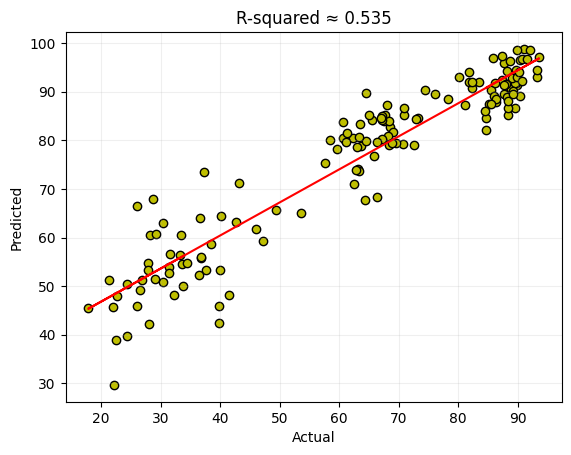

In [554]:
fig, ax = plt.subplots()
# ax.scatter(grouped_df2['Ground_Truth'].to_numpy(), grouped_df1['Inference'].to_numpy(), c='blue')
ax.scatter(grouped_df2['Ground_Truth'].to_numpy(), grouped_df1['Inference'].to_numpy(), c="y", edgecolors= "black")

m, b = np.polyfit(grouped_df2['Ground_Truth'], grouped_df1['Inference'].to_numpy(), 1)

# adding the regression line to the scatter plot
plt.plot(grouped_df2['Ground_Truth'].to_numpy(), m*grouped_df2['Ground_Truth'].to_numpy() + b, color='r')
# ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
ax.grid(alpha=0.2)
y_test, y_predicted = grouped_df2['Ground_Truth'].to_numpy().reshape(-1,1), grouped_df1['Inference'].to_numpy().reshape(-1,1)
ax.set_title("R-squared ≈ {:.3f}".format(r2_score(grouped_df2['Ground_Truth'].to_numpy(), grouped_df1['Inference'].to_numpy())))
# ax.plot(y_test, LinearRegression().fit(y_test, y_predicted).predict(y_test))

plt.show()

Text(0.5, 1.0, 'Residual plot')

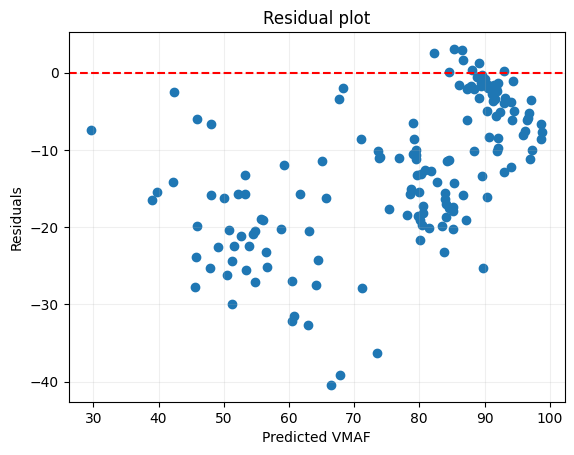

In [556]:
residuals = grouped_df2['Ground_Truth'].to_numpy() - grouped_df1['Inference'].to_numpy()
plt.scatter(grouped_df1['Inference'].to_numpy(), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(alpha=0.2)
plt.xlabel('Predicted VMAF')
plt.ylabel('Residuals')
plt.title('Residual plot')

Text(0.5, 1.0, 'Histogram of Residuals')

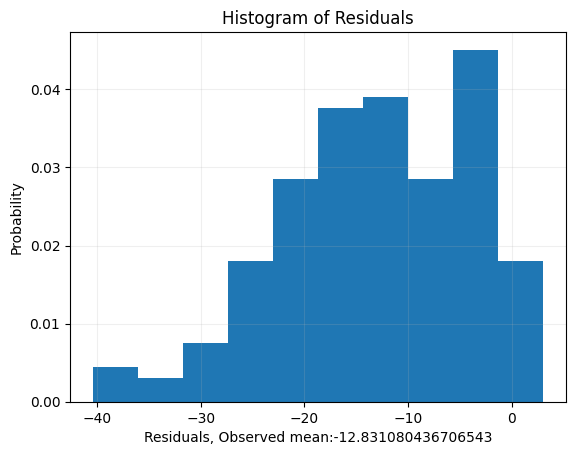

In [557]:
# Varför är medelvärdet av residualerna inte samma som average MAE?
"""mae = mean_absolute_error([grouped_df1['Inference']], [grouped_df2['Ground_Truth']], multioutput='raw_values')
print("Average error, sorted by movie, compression level and frame location is", mae.mean())"""

residuals = grouped_df2['Ground_Truth'].to_numpy() - grouped_df1['Inference'].to_numpy()
plt.hist(residuals, bins=10, density=True)
plt.grid(alpha=0.2)
plt.xlabel(f"Residuals, Observed mean:{residuals.mean()}")
plt.ylabel("Probability")
plt.title("Histogram of Residuals")

In [79]:
with open('vmaf_values_train.csv') as trainfile:
    train_dataframe = pd.DataFrame(csv.reader(trainfile, delimiter=","))
    train_dataframe.columns= train_dataframe.iloc[0]
    # train_dataframe = train_dataframe[1:]
    train_vmafs = []
    train_files = []
    for i in range(1, len(train_dataframe)):
        train_vmafs.append(float(train_dataframe.iloc[i][0]))
        train_files.append(train_dataframe.iloc[i][1])
    
    
with open('vmaf_values_TEST.csv') as testfile:
    test_dataframe = pd.DataFrame(csv.reader(testfile, delimiter=","))
    test_dataframe.columns= test_dataframe.iloc[0]
    # test_dataframe = test_dataframe[1:]
    test_vmafs = []
    test_files = []
    for j in range(1, len(test_dataframe)):
        test_vmafs.append(float(test_dataframe.iloc[j][0]))
        test_files.append(train_dataframe.iloc[i][1])

print(np.mean(train_vmafs))       
print(np.mean(test_vmafs))  

52.17888154778053
64.27545517043919


In [81]:
print(train_dataframe["Filename"])

0                                                 Filename
1        /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_t...
2        /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_t...
3        /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_t...
4        /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_t...
                               ...                        
25948    /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_t...
25949    /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_t...
25950    /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_t...
25951    /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_t...
25952    /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_t...
Name: Filename, Length: 25953, dtype: object


In [115]:
centers_train = train_dataframe[train_dataframe["Filename"].str.contains("center")]
corners_train = train_dataframe[(train_dataframe["Filename"].str.contains("bottom") | train_dataframe["Filename"].str.contains("top")) & (train_dataframe["Filename"].str.contains("left") | train_dataframe["Filename"].str.contains("right"))]
edges_train = train_dataframe[(train_dataframe["Filename"].str.contains("bottom") | train_dataframe["Filename"].str.contains("top") | train_dataframe["Filename"].str.contains("right") | train_dataframe["Filename"].str.contains("left"))] 

train_dataframe['Position'] = 'Other'   # alla positioner som inte tillhör kategorierna ovan
train_dataframe.loc[train_dataframe.index.isin(edges_train.index), 'Position'] = 'Edge'
train_dataframe.loc[train_dataframe.index.isin(corners_train.index), 'Position'] = 'Corner'
train_dataframe.loc[train_dataframe.index.isin(centers_train.index), 'Position'] = 'Center'

print(train_dataframe)

corners_train = train_dataframe.loc[train_dataframe['Position'] == 'Corner']
corners_compression_23_train = corners_train[corners_train.Filename.str.contains('23')]
corners_compression_50_train = corners_train[corners_train.Filename.str.contains('50')]
corners_compression_51_train = corners_train[corners_train.Filename.str.contains('75')].replace('75', '51')

centers_train = train_dataframe.loc[train_dataframe['Position'] == 'Center']
centers_compression_23_train = centers_train[centers_train.Filename.str.contains('23')]
centers_compression_50_train = centers_train[centers_train.Filename.str.contains('50')]
centers_compression_51_train = centers_train[centers_train.Filename.str.contains('75')].replace('75', '51')

edges_train = train_dataframe.loc[train_dataframe['Position'] == 'Edge']
edges_compression_23_train = edges_train[edges_train.Filename.str.contains('23')]
edges_compression_50_train = edges_train[edges_train.Filename.str.contains('50')]
edges_compression_51_train = edges_train[edges_train.Filename.str.contains('75')].replace('75', '51')

0      VMAF Score                                           Filename Position  \
0      VMAF Score                                           Filename    Other   
1       97.427361  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_t...   Corner   
2       97.427361  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_t...   Corner   
3       97.427361  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_t...   Corner   
4       97.427361  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_t...   Corner   
...           ...                                                ...      ...   
25948   18.321270  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_t...     Edge   
25949   17.864878  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_t...     Edge   
25950    6.324088  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_t...     Edge   
25951    5.902952  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_t...   Center   
25952    5.019127  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_t...     Edge   

0                          

In [137]:
print(len(test_dataframe))

5921


In [143]:
low_test = test_dataframe[test_dataframe["Filename"].str.contains("23")]
high_test = test_dataframe[test_dataframe["Filename"].str.contains("50")]
higher_test = test_dataframe[test_dataframe["Filename"].str.contains("51")]

low_train = train_dataframe[train_dataframe["Filename"].str.contains("23")]
high_train = train_dataframe[train_dataframe["Filename"].str.contains("50")]
higher_train = train_dataframe[train_dataframe["Filename"].str.contains("51")]

print(len(low_test) / (len(low_test) + len(high_test) + len(higher_test)))
print(len(high_test) / (len(low_test) + len(high_test) + len(higher_test)))
print(len(higher_test) / (len(low_test) + len(high_test) + len(higher_test)))

print()

print(len(low_train) / (len(low_train) + len(high_train) + len(higher_train)))
print(len(high_train) / (len(low_train) + len(high_train) + len(higher_train)))
print(len(higher_train) / (len(low_train) + len(high_train) + len(higher_train)))

0.39357429718875503
0.5983935742971888
0.008032128514056224

0.2681318681318681
0.7120879120879121
0.01978021978021978


In [119]:
centers_test = test_dataframe[test_dataframe["Filename"].str.contains("center")]
corners_test = test_dataframe[(test_dataframe["Filename"].str.contains("bottom") | test_dataframe["Filename"].str.contains("top")) & (test_dataframe["Filename"].str.contains("left") | test_dataframe["Filename"].str.contains("right"))]
edges_test = test_dataframe[(test_dataframe["Filename"].str.contains("bottom") | test_dataframe["Filename"].str.contains("top") | test_dataframe["Filename"].str.contains("right") | test_dataframe["Filename"].str.contains("left"))] 

test_dataframe['Position'] = 'Other'   # alla positioner som inte tillhör kategorierna ovan
test_dataframe.loc[test_dataframe.index.isin(edges_test.index), 'Position'] = 'Edge'
test_dataframe.loc[test_dataframe.index.isin(corners_test.index), 'Position'] = 'Corner'
test_dataframe.loc[test_dataframe.index.isin(centers_test.index), 'Position'] = 'Center'

print(test_dataframe)

corners_test = test_dataframe.loc[test_dataframe['Position'] == 'Corner']
corners_compression_23_test = corners_test[corners_test.Filename.str.contains('23')]
corners_compression_50_test = corners_test[corners_test.Filename.str.contains('50')]
corners_compression_51_test = corners_test[corners_test.Filename.str.contains('75')].replace('75', '51')

centers_test = test_dataframe.loc[test_dataframe['Position'] == 'Center']
centers_compression_23_test = centers_test[centers_test.Filename.str.contains('23')]
centers_compression_50_test = centers_test[centers_test.Filename.str.contains('50')]
centers_compression_51_test = centers_test[centers_test.Filename.str.contains('75')].replace('75', '51')

edges_test = test_dataframe.loc[test_dataframe['Position'] == 'Edge']
edges_compression_23_test = edges_test[edges_test.Filename.str.contains('23')]
edges_compression_50_test = edges_test[edges_test.Filename.str.contains('50')]
edges_compression_51_test = edges_test[edges_test.Filename.str.contains('75')].replace('75', '51')

0     VMAF Score                                           Filename Position
0     VMAF Score                                           Filename    Other
1      97.427361  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...   Corner
2      97.427361  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...   Corner
3      97.427361  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...   Corner
4      97.427361  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...   Corner
...          ...                                                ...      ...
5916   15.288772  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     Edge
5917   33.728546  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     Edge
5918    8.276562  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     Edge
5919    8.895346  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...   Center
5920   24.329753  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     Edge

[5921 rows x 3 columns]


In [132]:
print("compression 51, train:")
print(len(corners_compression_51_train) + len(centers_compression_51_train) + len(edges_compression_51_train))
print("compression 51, test:")
print(len(corners_compression_51_test) + len(centers_compression_51_test) + len(edges_compression_51_test))
print("compression 50, train:")
print(len(corners_compression_50_train) + len(centers_compression_50_train) + len(edges_compression_50_train))
print("compression 50, test:")
print(len(corners_compression_50_test) + len(centers_compression_51_test) + len(edges_compression_50_test))
print("compression 23, train:")
print(len(corners_compression_23_train) + len(centers_compression_23_train) + len(edges_compression_23_train))
print("compression 23, test:")
print(len(corners_compression_23_test) + len(centers_compression_23_test) + len(edges_compression_23_test))

print()
print("Total amount of corners, test set:")
print(len(corners_compression_51_test) + len(corners_compression_50_test) + len(corners_compression_23_test))
print("Andel corners med kompression 51:")
print(len(corners_compression_51_test) / (len(corners_compression_51_test) + len(corners_compression_50_test) + len(corners_compression_23_test)))

print()
print("Total amount of corners, train set:")
print(len(corners_compression_51_train) + len(corners_compression_50_train) + len(corners_compression_23_train))
print("Andel corners med kompression 51:")
print(len(corners_compression_51_train) / (len(corners_compression_51_train) + len(corners_compression_50_train) + len(corners_compression_23_train)))

print()
print("Total amount of compression 51, train set:")
print(len(corners_compression_51_train) + len(centers_compression_51_train) + len(edges_compression_51_train))
print("Andel corners med kompression 51:")
print(((len(corners_compression_51_train) + len(centers_compression_51_train) + len(edges_compression_51_train))) / 5920)


compression 51, train:
14944
compression 51, test:
2080
compression 50, train:
20736
compression 50, test:
4684
compression 23, train:
7808
compression 23, test:
3136

Total amount of corners, test set:
2496
Andel corners med kompression 51:
0.20833333333333334

Total amount of corners, train set:
10872
Andel corners med kompression 51:
0.34363502575423105

Total amount of compression 51, train set:
14944
Andel corners med kompression 51:
2.5243243243243243


In [477]:
# klassificera i genrer? Jämför med träningsdata.
# jämför plots 10% tränad modell med 100%
# hur stor felmarginal är ok? Gör om till classification-problem: precision och recall? Area under kurvan, variera tröskel

tot_errors = len(mae)
acceptable_errors = []
non_acceptable_errors = []
for e in mae:
    if e <= 6:
        acceptable_errors.append(e)
        
    else:
        non_acceptable_errors.append(e)

print(tot_errors)
      
print(len(acceptable_errors))

print(len(acceptable_errors) / tot_errors)

17760
3522
0.1983108108108108


In [479]:
# print(grouped_df1['Inference'])
# print(grouped_df2['Ground_Truth'])
"""print(len(grouped_df1['Inference']))
print(len(grouped_df2['Ground_Truth']))"""

print(grouped_df2['Ground_Truth'].mean())
print(grouped_df2['Ground_Truth'].std())

63.710632
23.327286


In [480]:
# Confidence interval of estimate

# create 95% confidence interval 
# for population mean weight 
alpha = 0.99
st.norm.interval(alpha, loc=np.mean(grouped_df1['Inference']), scale=st.sem(grouped_df1['Inference'])) 

(73.03627538317818, 80.04712915783745)

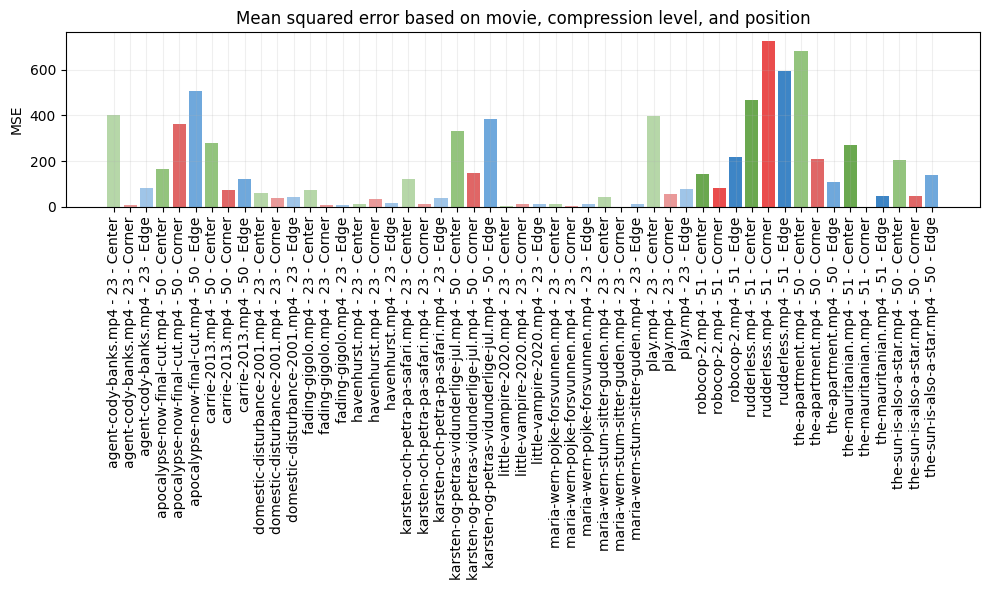

In [891]:
grouped_df1 = test_df.groupby(['Movie_Name', 'Compression_Level', 'Position'])['Inference'].mean().reset_index()
grouped_df2 = test_df.groupby(['Movie_Name', 'Compression_Level', 'Position'])['Ground_Truth'].mean().reset_index()

categories = [f"{movie} - {compression} - {position}" for movie, compression, position in zip(grouped_df['Movie_Name'], grouped_df['Compression_Level'].replace('75', '51'), grouped_df['Position'])]
mse = mean_squared_error([grouped_df1['Inference']], [grouped_df2['Ground_Truth']], multioutput='raw_values')

# print(mae)

plt.figure(figsize=(10, 6))
plt.bar(categories, mse, color=colors(categories))
plt.title('Mean squared error based on movie, compression level, and position')
plt.ylabel('MSE')
plt.xticks(rotation=90)
# plt.ylim(0, 30)
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()

In [674]:
df = pd.read_csv("inference_ALL.csv")

In [675]:
print(df)

                                              Image_Path  Ground_Truth  \
0      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427360   
1      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427360   
2      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427360   
3      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427360   
4      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427360   
...                                                  ...           ...   
17755  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      9.618851   
17756  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     31.796865   
17757  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      7.720450   
17758  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      3.858760   
17759  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     23.807552   

        Inference Position  Compression_Level                  Movie_Name  
0      106.869060   Corner         

In [705]:
grouped_df_23 = df.where(df['Compression_Level'] == 23).dropna()

# print(grouped_df_23.dropna())

mae_23 = mean_absolute_error([grouped_df_23['Ground_Truth']], [grouped_df_23['Inference']], multioutput='raw_values')

r_squared_23 = r2_score(grouped_df_23['Ground_Truth'], grouped_df_23['Inference'])
print("R^2 score of model performance, sorted by movie, compression level and frame location is", r_squared_23)
print("Average Error is ", mae_23.mean())

R^2 score of model performance, sorted by movie, compression level and frame location is -4.835902232511961
Average Error is  11.210396228238244


In [697]:
df_train = pd.read_csv('vmaf_values_train_ALL.csv')
print(np.mean(df_train['VMAF Score']))
print(np.std(df_train['VMAF Score']))

64.55760965689223
30.88804857975737


In [676]:
# print(df)

gt_mean = np.mean(df['Ground_Truth'])
gt_std = np.std(df['Ground_Truth'])
pred_mean = np.mean(df['Inference'])
pred_std = np.std(df['Inference'])

print(gt_mean)
print(gt_std)

print(pred_mean)
print(pred_std)


64.51428085140765
30.416334290550253
77.56743854456644
27.23093644707146


In [677]:
df['Ground_Truth'] = (df['Ground_Truth'] - df['Ground_Truth'].mean()) / df['Ground_Truth'].std() # z-score normalization
df['Inference'] = (df['Inference'] - df['Inference'].mean()) / df['Inference'].std()

In [678]:
print(df)

                                              Image_Path  Ground_Truth  \
0      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      1.082055   
1      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      1.082055   
2      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      1.082055   
3      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      1.082055   
4      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      1.082055   
...                                                  ...           ...   
17755  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     -1.804750   
17756  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     -1.075623   
17757  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     -1.867162   
17758  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     -1.994120   
17759  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     -1.338280   

       Inference Position  Compression_Level                  Movie_Name  
0       1.076011   Corner           

In [679]:
df['Ground_Truth'] = df['Ground_Truth']*gt_std+gt_mean    # denormalization
df['Inference'] = df['Inference']*pred_std+pred_mean

In [680]:
print(df)

                                              Image_Path  Ground_Truth  \
0      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.426433   
1      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.426433   
2      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.426433   
3      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.426433   
4      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.426433   
...                                                  ...           ...   
17755  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      9.620397   
17756  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     31.797786   
17757  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      7.722049   
17758  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      3.860468   
17759  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     23.808698   

        Inference Position  Compression_Level                  Movie_Name  
0      106.868235   Corner         

In [580]:
# tensor = torch.tensor(test_df.values())

test_df['Ground_Truth'] = (test_df['Ground_Truth'] - test_df['Ground_Truth'].mean()) / test_df['Ground_Truth'].std() # z-score normalization
test_df['Inference'] = (test_df['Inference'] - test_df['Inference'].mean()) / test_df['Inference'].std()
# torch.save(tensor, 'data.pt')

In [646]:
test_df['Ground_Truth'] = (test_df['Ground_Truth'] + test_df['Ground_Truth'].mean()) * test_df['Ground_Truth'].std() 
test_df['Inference'] = (test_df['Inference'] + test_df['Inference'].mean()) * test_df['Inference'].std()

In [647]:
print(test_df)

                                              Image_Path  Ground_Truth  \
0      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      1.082055   
1      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      1.082055   
2      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      1.082055   
3      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      1.082055   
4      /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      1.082055   
...                                                  ...           ...   
17755  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     -1.804750   
17756  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     -1.075623   
17757  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     -1.867163   
17758  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     -1.994120   
17759  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     -1.338281   

       Inference Position Compression_Level                  Movie_Name  
0       1.076010   Corner            

In [706]:
grouped_df1 = df.groupby(['Movie_Name', 'Compression_Level', 'Position'])['Inference'].mean().reset_index()
grouped_df2 = df.groupby(['Movie_Name', 'Compression_Level', 'Position'])['Ground_Truth'].mean().reset_index()
mae = mean_absolute_error([grouped_df2['Ground_Truth']], [grouped_df1['Inference']], multioutput='raw_values')

r_squared = r2_score(grouped_df2['Ground_Truth'], grouped_df1['Inference'])
print("R^2 score of model performance, sorted by movie, compression level and frame location is", r_squared)
print("Average Error is ", mae.mean())

R^2 score of model performance, sorted by movie, compression level and frame location is 0.5349269059925605
Average Error is  12.98964417737951


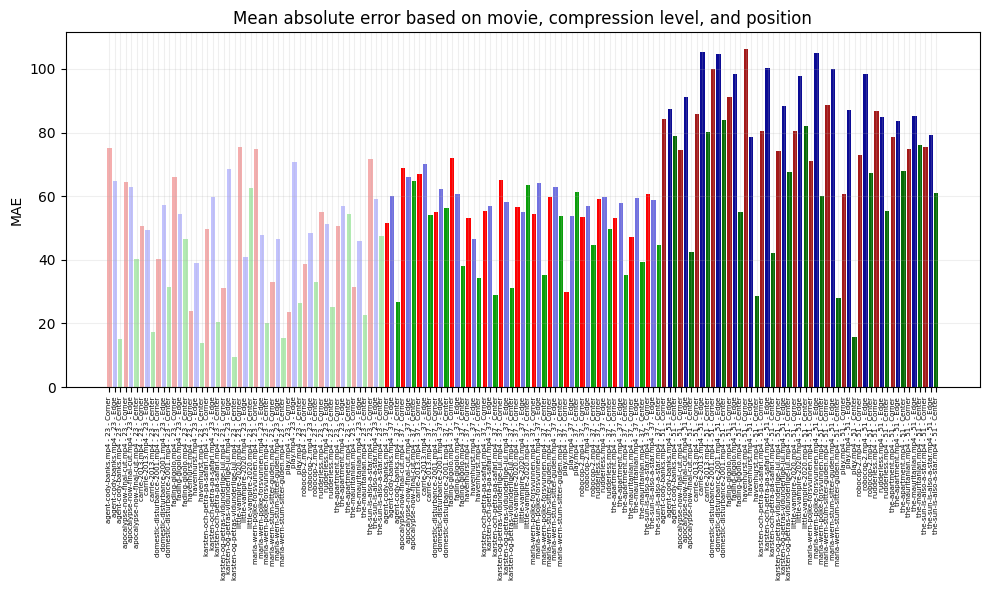

In [682]:
plt.figure(figsize=(10, 6))
mae = mean_absolute_error([df['Ground_Truth']], [df['Inference']], multioutput='raw_values')
categories = [f"{movie} - {compression} - {position}" for movie, compression, position in zip(df['Movie_Name'], df['Compression_Level'], df['Position'])]
plt.bar(categories, mae, color=colors(categories))
plt.title('Mean absolute error based on movie, compression level, and position')
plt.ylabel('MAE')
plt.xticks(rotation=90, fontsize=5)
# plt.ylim(0, 30)
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()

In [683]:
def colors(categories):
    colors = []
    for cat in categories:
        if "Corner" in cat:
            if "23" in cat:
                colors.append("#f5adad")
                
            elif "37" in cat:
                colors.append("#ff0000")
                
            elif "51" in cat:
                colors.append("#a41919")
                
        elif "Center" in cat:
            if "23" in cat:
                colors.append("#b2ebb2")
                
            elif "37" in cat:
                colors.append("#099f09")
                
            elif "51" in cat:
                colors.append("#056c05")
            
        elif "Edge" in cat:
            if "23" in cat:
                colors.append("#c2c2fe")
                
            elif "37" in cat:
                colors.append("#7171e2")
                
            elif "51" in cat:
                colors.append("#0b0b95")  
        
    return colors

[32, 34, 35, 37, 41, 42, 44, 52, 55, 56, 64, 65, 69, 72, 75, 76, 78, 80, 82, 91, 94, 98, 99, 106, 118, 119, 120, 121, 122, 127, 135, 138, 139, 140, 141, 145, 146, 147, 152]


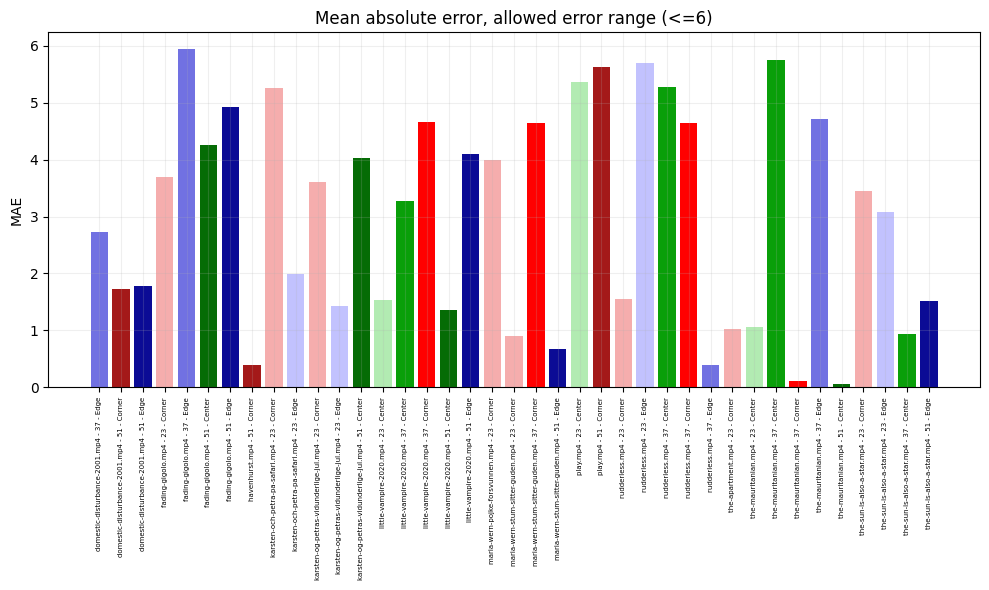

In [684]:
indices = []

for i in range(len(grouped_df1['Inference'])):
    if mae[i] <= 6:
        indices.append(i)
        
        
categories = [f"{movie} - {compression} - {position}" for movie, compression, position in zip(grouped_df1['Movie_Name'][[i for i in indices]], grouped_df1['Compression_Level'].replace('75', '51')[[i for i in indices]], grouped_df1['Position'][[i for i in indices]])]


print(indices)


plt.figure(figsize=(10, 6))
plt.bar(categories, mae[[i for i in indices]], color=colors(categories))
plt.title('Mean absolute error, allowed error range (<=6)')
plt.ylabel('MAE')
plt.xticks(rotation=90, fontsize=5)
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()

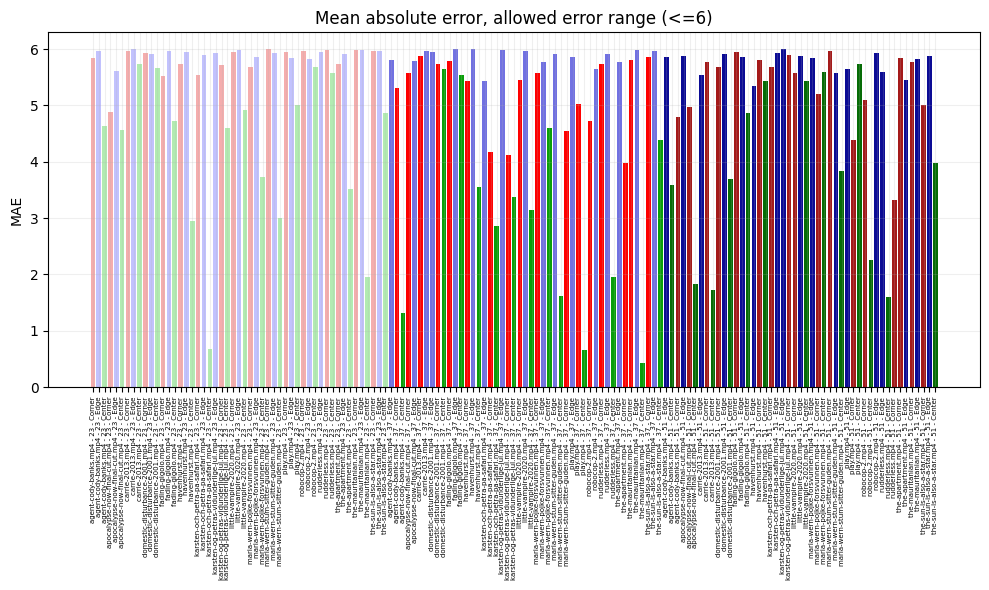

In [686]:
indices = []

for i in range(len(df['Inference'])):
    if mae[i] <= 6:
        indices.append(i)
        
        
categories = [f"{movie} - {compression} - {position}" for movie, compression, position in zip(df['Movie_Name'][[i for i in indices]], df['Compression_Level'][[i for i in indices]], df['Position'][[i for i in indices]])]


# print(indices)


plt.figure(figsize=(10, 6))
plt.bar(categories, mae[[i for i in indices]], color=colors(categories))
plt.title('Mean absolute error, allowed error range (<=6)')
plt.ylabel('MAE')
plt.xticks(rotation=90, fontsize=5)
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()

In [691]:
grouped_df1 = df.groupby(['Movie_Name', 'Compression_Level', 'Position'])['Inference'].mean().reset_index()
grouped_df2 = df.groupby(['Movie_Name', 'Compression_Level', 'Position'])['Ground_Truth'].mean().reset_index()

print(grouped_df2)

                     Movie_Name  Compression_Level Position  Ground_Truth
0          agent-cody-banks.mp4                 23   Center     84.749037
1          agent-cody-banks.mp4                 23   Corner     85.248119
2          agent-cody-banks.mp4                 23     Edge     84.684676
3          agent-cody-banks.mp4                 37   Center     66.379581
4          agent-cody-banks.mp4                 37   Corner     70.713560
..                          ...                ...      ...           ...
148  the-sun-is-also-a-star.mp4                 37   Corner     68.388858
149  the-sun-is-also-a-star.mp4                 37     Edge     68.844392
150  the-sun-is-also-a-star.mp4                 51   Center     24.364734
151  the-sun-is-also-a-star.mp4                 51   Corner     40.053639
152  the-sun-is-also-a-star.mp4                 51     Edge     33.817227

[153 rows x 4 columns]


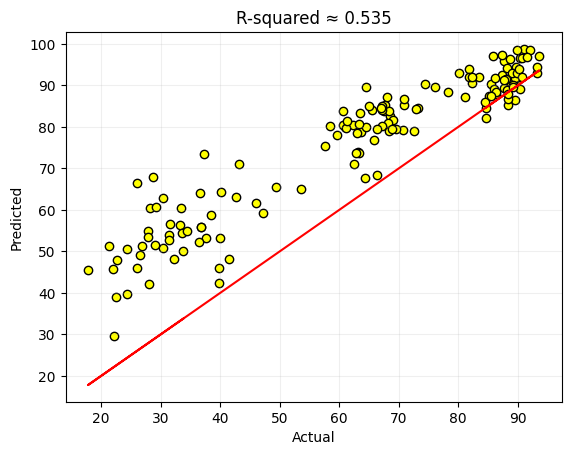

In [694]:
fig, ax = plt.subplots()

# ax.scatter(grouped_df2['Ground_Truth'].to_numpy(), grouped_df1['Inference'].to_numpy(), c='blue')
ax.scatter(grouped_df2['Ground_Truth'].to_numpy(), grouped_df1['Inference'].to_numpy(), c='yellow', edgecolors= "black")

# m, b = np.polyfit(sorted(grouped_df2['Ground_Truth'].to_numpy()), sorted(grouped_df1['Inference'].to_numpy()), 1)
m, b = np.polyfit(sorted(grouped_df2['Ground_Truth'].to_numpy()), sorted(grouped_df2['Ground_Truth'].to_numpy()), 1)

# adding the regression line to the scatter plot
plt.plot(grouped_df2['Ground_Truth'].to_numpy(), m*grouped_df2['Ground_Truth'].to_numpy() + b, color='r')

plt.grid(alpha=0.2)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("R-squared ≈ {:.3f}".format(r2_score(grouped_df2['Ground_Truth'].to_numpy(), grouped_df1['Inference'].to_numpy())))


plt.show()

Text(0.5, 1.0, 'Residual plot')

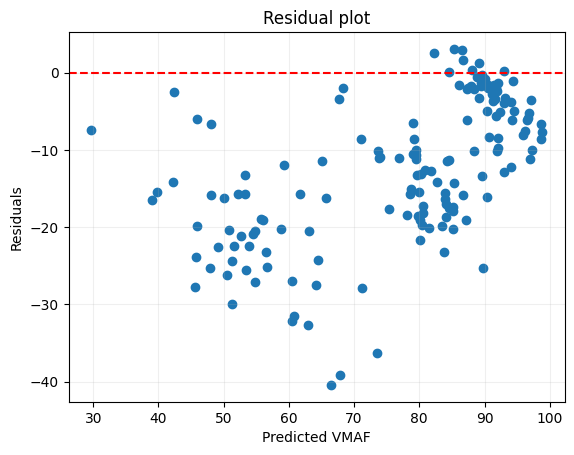

In [695]:
residuals = grouped_df2['Ground_Truth'].to_numpy() - grouped_df1['Inference'].to_numpy()
plt.scatter(grouped_df1['Inference'].to_numpy(), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(alpha=0.2)
plt.xlabel('Predicted VMAF')
plt.ylabel('Residuals')
plt.title('Residual plot')

Text(0.5, 1.0, 'Histogram of Residuals')

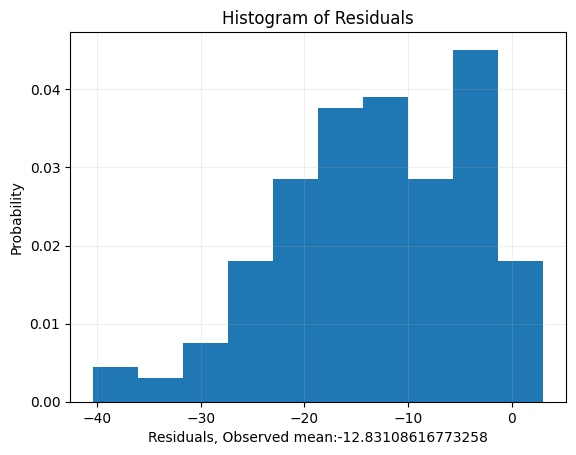

In [696]:
residuals = grouped_df2['Ground_Truth'].to_numpy() - grouped_df1['Inference'].to_numpy()
plt.hist(residuals, bins=10, density=True)
plt.grid(alpha=0.2)
plt.xlabel(f"Residuals, Observed mean:{residuals.mean()}")
plt.ylabel("Probability")
plt.title("Histogram of Residuals")

In [1048]:
# ≈ 10 % of data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = DenseNet(num_channels=3)

model2.to(device)

criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)  

In [1045]:
print(len(train_loader))
print(len(train_loader) / 10)
print(len(val_loader))

234
23.4
26


In [1049]:
train_losses = []
val_losses = []
batch_running_losses = []
num_epochs = 5  

for epoch in range(num_epochs):
    start_epoch_time = time.time()
    model2.train()
    running_loss = 0.0     # nollställs för varje epoch
    
    torch.manual_seed(2)        
    for i, data in enumerate(train_loader, 0):      # 0 is start index, 234 is end
        if i >= 20:       
            break
        
        batch_running_loss = 0.0
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  
        
        outputs = model2(inputs)     
        
        training_loss = criterion(outputs, labels)
        train_losses.append(training_loss.item()) 
        running_loss += training_loss.item()
        batch_running_loss += training_loss.item()
        
        with open("train2.txt", "a") as f:
                f.write(str(training_loss.item()))
                f.write('\n')
        
        training_loss.backward()     # backward pass
        
        optimizer.step()             # step
        
        if i % 5 == 0:
        
            val_loss = evaluate(model2, val_loader)
            val_losses.append(val_loss)    
            with open("val2.txt", "a") as f2:
                f2.write(str(val_loss))
                f2.write('\n')
                
            model2.train()
            
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, batch_running_loss))
        batch_running_losses.append(batch_running_loss)
        batch_running_loss = 0.0
            
        
        avg_loss_per_epoch = running_loss / len(train_loader)
        """if i % 100 == 0:
            epoch_loss = running_loss / len(train_losses)
            # print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss}, Validation Loss: {val_loss}")
            with open("train.txt", "a") as f:
                f.write(str(running_loss / 100))
                f.write('\n')
            running_loss = 0.0"""
        
    end_epoch_time = time.time()  # End timer for epoch
    epoch_time = end_epoch_time - start_epoch_time
    print(f"Epoch {epoch+1} took {epoch_time} seconds")
    print(f"Avg loss for epoch {epoch+1} is  {avg_loss_per_epoch}")


print("Done!")

[1,     1] loss: 3355.293
[1,     2] loss: 1389.270
[1,     3] loss: 86612.289
[1,     4] loss: 1448.479
[1,     5] loss: 3394.237
[1,     6] loss: 4146.357
[1,     7] loss: 4015.124
[1,     8] loss: 4250.376
[1,     9] loss: 3400.547
[1,    10] loss: 3213.934
[1,    11] loss: 3083.145
[1,    12] loss: 2431.388
[1,    13] loss: 1790.550
[1,    14] loss: 2201.915
[1,    15] loss: 1786.221
[1,    16] loss: 1613.277
[1,    17] loss: 1430.558
[1,    18] loss: 1724.266
[1,    19] loss: 1590.228
[1,    20] loss: 1170.108
Epoch 1 took 1301.1796872615814 seconds
Avg loss for epoch 1 is  572.8528322399172
[2,     1] loss: 1297.266
[2,     2] loss: 1156.985
[2,     3] loss: 1129.016
[2,     4] loss: 1175.869
[2,     5] loss: 1158.486
[2,     6] loss: 1146.753
[2,     7] loss: 1089.112
[2,     8] loss: 941.715
[2,     9] loss: 1012.505
[2,    10] loss: 879.214
[2,    11] loss: 750.299
[2,    12] loss: 686.902
[2,    13] loss: 829.650
[2,    14] loss: 771.672
[2,    15] loss: 946.302
[2,    16] lo

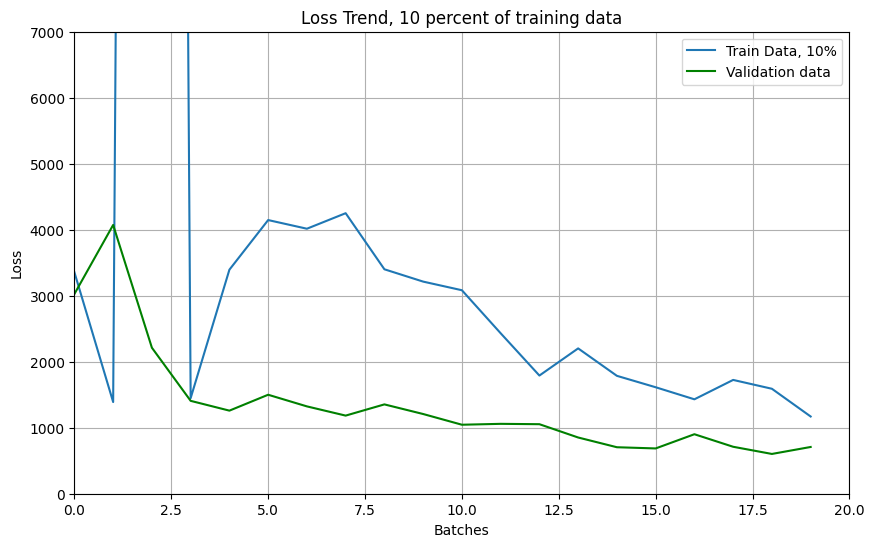

In [1202]:
losses = []
validation = []

with open('train2.txt', 'r') as f:
    for loss in f:
        losses.append(float(loss))
        
with open('val2.txt', 'r') as f2:
    for loss in f2:
        validation.append(float(loss))
        

plt.figure(figsize=(10, 6))
plt.plot(losses[0:20], label='Train Data, 10%')
plt.plot(validation, label='Validation data', color='g')

plt.xlabel('Batches')
plt.ylabel('Loss')
plt.ylim(0, 7000)
plt.xlim(0,20)
plt.title('Loss Trend, 10 percent of training data')
plt.legend()
plt.grid(True)
plt.show()

In [1054]:
predictions, true_labels, image_paths = test_model(model2, test_loader)
test_df = pd.DataFrame({'Image_Path': image_paths, 'Ground_Truth': true_labels, 'Inference': predictions}) # plocka ut bara komp_nivå, film och crop

In [1056]:
centers = test_df[test_df["Image_Path"].str.contains("center")]
corners = test_df[(test_df["Image_Path"].str.contains("bottom") | test_df["Image_Path"].str.contains("top")) & (test_df["Image_Path"].str.contains("left") | test_df["Image_Path"].str.contains("right"))]
edges = test_df[(test_df["Image_Path"].str.contains("bottom") | test_df["Image_Path"].str.contains("top") | test_df["Image_Path"].str.contains("right") | test_df["Image_Path"].str.contains("left"))] 

test_df['Position'] = 'Other'   # alla positioner som inte tillhör kategorierna ovan
test_df.loc[test_df.index.isin(edges.index), 'Position'] = 'Edge'
test_df.loc[test_df.index.isin(corners.index), 'Position'] = 'Corner'
test_df.loc[test_df.index.isin(centers.index), 'Position'] = 'Center'

test_df['Compression_Level'] = test_df['Image_Path'].apply(lambda x: x.split('_')[7].split('_frame')[0])
test_df['Movie_Name'] = test_df['Image_Path'].apply(lambda x: x.split('_')[8].split('_frame')[0])

print(test_df)

test_df.to_csv('inference_10%.csv', index=False)

                                             Image_Path  Ground_Truth  \
0     /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427361   
1     /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427361   
2     /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427361   
3     /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427361   
4     /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427361   
...                                                 ...           ...   
5915  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     15.288772   
5916  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     33.728546   
5917  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      8.276562   
5918  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      8.895346   
5919  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     24.329754   

      Inference Position Compression_Level                  Movie_Name  
0     79.414597   Corner                23        

In [1194]:
test_df = pd.read_csv('inference_10%.csv')
average_ground_truth = test_df.groupby('Movie_Name')['Ground_Truth'].mean()

average_vmaf_pred = test_df.groupby('Movie_Name')['Inference'].mean()

In [1210]:
corners = test_df.loc[test_df['Position'] == 'Corner']
corners_compression_23 = corners.loc[corners['Compression_Level'] == '23']
corners_compression_50 = corners.loc[corners['Compression_Level'] == '50']
corners_compression_51 = corners.loc[corners['Compression_Level'] == '75'].replace('75', '51')

centers = test_df.loc[test_df['Position'] == 'Center']
centers_compression_23 = centers.loc[centers['Compression_Level'] == '23']
centers_compression_50 = centers.loc[centers['Compression_Level'] == '50']
centers_compression_51 = centers.loc[centers['Compression_Level'] == '75'].replace('75', '51')

edges = test_df.loc[test_df['Position'] == 'Edge']
edges_compression_23 = edges.loc[edges['Compression_Level'] == '23']
edges_compression_50 = edges.loc[edges['Compression_Level'] == '50']
edges_compression_51 = edges.loc[edges['Compression_Level'] == '75'].replace('75', '51')

avg_vmaf_true = [sum(corners_compression_23['Ground_Truth'])/len(corners_compression_23['Ground_Truth']), sum(corners_compression_50['Ground_Truth'])/ len(corners_compression_50['Ground_Truth']), sum(corners_compression_51['Ground_Truth'])/len(corners_compression_51['Ground_Truth']), sum(centers_compression_23['Ground_Truth'])/len(centers_compression_23['Ground_Truth']), sum(centers_compression_50['Ground_Truth'])/len(centers_compression_50['Ground_Truth']), sum(centers_compression_51['Ground_Truth'])/len(centers_compression_51['Ground_Truth']), sum(edges_compression_23['Ground_Truth'])/len(edges_compression_23['Ground_Truth']), sum(edges_compression_50['Ground_Truth'])/len(edges_compression_50['Ground_Truth']), sum(edges_compression_51['Ground_Truth'])/len(edges_compression_51['Ground_Truth'])]
avg_vmaf_pred = [sum(corners_compression_23['Inference'])/len(corners_compression_23['Inference']), sum(corners_compression_50['Inference'])/ len(corners_compression_50['Inference']), sum(corners_compression_51['Inference'])/len(corners_compression_51['Inference']), sum(centers_compression_23['Inference'])/len(centers_compression_23['Inference']), sum(centers_compression_50['Inference'])/len(centers_compression_50['Inference']), sum(centers_compression_51['Inference'])/len(centers_compression_51['Inference']), sum(edges_compression_23['Inference'])/len(edges_compression_23['Inference']), sum(edges_compression_50['Inference'])/len(edges_compression_50['Inference']), sum(edges_compression_51['Inference'])/len(edges_compression_51['Inference'])]

abs_diffs_movies = []
for movie in test_df['Movie_Name'].unique():
    abs_diff = abs(average_ground_truth[movie] - average_vmaf_pred[movie])
    abs_diffs_movies.append(abs_diff)

r_squared = r2_score(average_ground_truth, average_vmaf_pred)
print("R^2 score of model performance is", r_squared)

plt.plot(average_ground_truth, label="Average ground truth VMAF")
plt.plot(average_vmaf_pred, label="Average predicted VMAF")
plt.legend(fontsize='small')
plt.title('Average VMAF values based on movie: true and predicted values')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')  
plt.grid(alpha=0.2)
plt.show()


ZeroDivisionError: division by zero

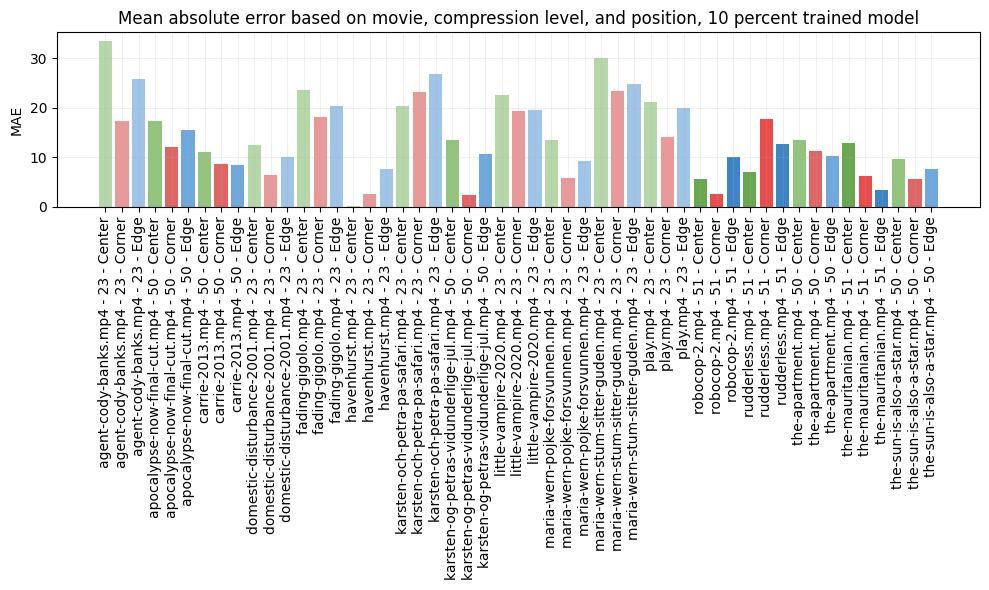

In [1214]:
grouped_df = grouped_df1 = test_df.groupby(['Movie_Name', 'Compression_Level', 'Position'])

grouped_df1 = test_df.groupby(['Movie_Name', 'Compression_Level', 'Position'])['Inference'].mean().reset_index()
grouped_df2 = test_df.groupby(['Movie_Name', 'Compression_Level', 'Position'])['Ground_Truth'].mean().reset_index()

mae = mean_absolute_error([grouped_df1['Inference']], [grouped_df2['Ground_Truth']], multioutput='raw_values')

# print(mae)

categories = [f"{movie} - {compression} - {position}" for movie, compression, position in zip(grouped_df1['Movie_Name'], grouped_df1['Compression_Level'].replace(75, 51), grouped_df1['Position'])]

def colors(categories):
    colors = []
    for cat in categories:
        if "Corner" in cat:
            if "23" in cat:
                colors.append("#ea9999")
                
            elif "50" in cat:
                colors.append("#e06666")
                
            elif "51" in cat:
                colors.append("#ea4c4c")
                
        elif "Center" in cat:
            if "23" in cat:
                colors.append("#b6d7a8")
                
            elif "50" in cat:
                colors.append("#93c47d")
                
            elif "51" in cat:
                colors.append("#6aa84f")
            
        elif "Edge" in cat:
            if "23" in cat:
                colors.append("#9fc5e8")
                
            elif "50" in cat:
                colors.append("#6fa8dc")
                
            elif "51" in cat:
                colors.append("#3d85c6")  
        
    return colors

plt.figure(figsize=(10, 6))
plt.bar(categories, mae, color=colors(categories))
plt.title('Mean absolute error based on movie, compression level, and position, 10 percent trained model')
plt.ylabel('MAE')
plt.xticks(rotation=90)
# plt.ylim(0, 30)
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()

In [1201]:
print("Average error, sorted by movie, compression level and frame location is", mae.mean())
r_squared = r2_score(grouped_df2['Ground_Truth'], grouped_df1['Inference'])
print("R^2 score of model performance, sorted by movie, compression level and frame location is", r_squared)

Average error, sorted by movie, compression level and frame location is 13.849955172423815
R^2 score of model performance, sorted by movie, compression level and frame location is 0.6607880045300947


In [1203]:
# Visar att modellen presterar sämre med mindre träning
tot_errors = len(mae)
acceptable_errors = []
non_acceptable_errors = []
for e in mae:
    if e <= 6:
        acceptable_errors.append(e)
        
    else:
        non_acceptable_errors.append(e)

print(tot_errors)
      
print(len(acceptable_errors))

print(len(acceptable_errors) / tot_errors)

51
8
0.1568627450980392


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 50]


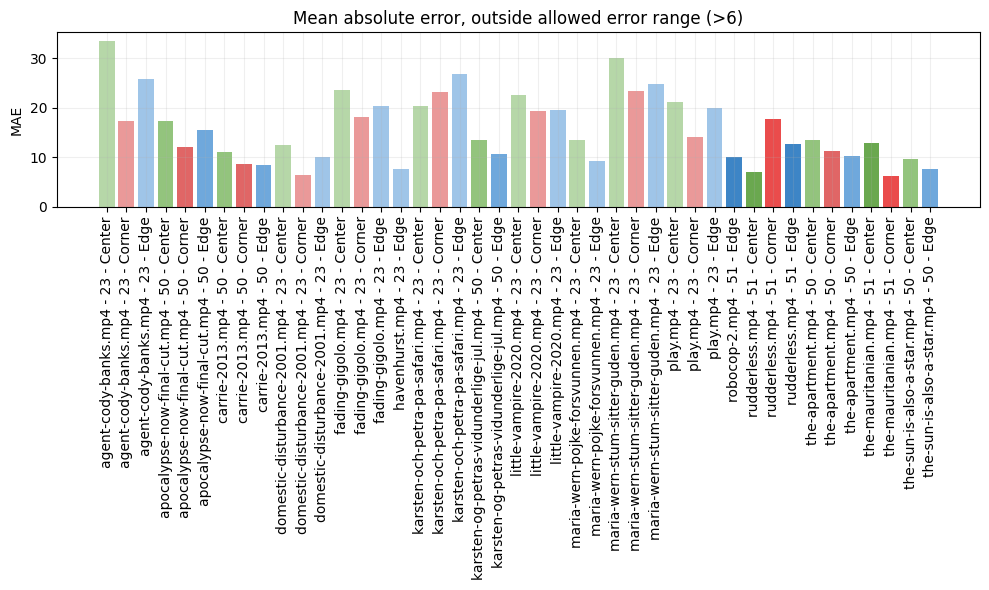

In [1216]:
indices = []

for i in range(len(grouped_df1['Inference'])):
    if mae[i] > 6:
        indices.append(i)
        
categories = [f"{movie} - {compression} - {position}" for movie, compression, position in zip(grouped_df1['Movie_Name'][[i for i in indices]], grouped_df1['Compression_Level'].replace(75, 51)[[i for i in indices]], grouped_df1['Position'][[i for i in indices]])]


print(indices)


plt.figure(figsize=(10, 6))
plt.bar(categories, mae[[i for i in indices]], color=colors(categories))
plt.title('Mean absolute error, outside allowed error range (>6)')
plt.ylabel('MAE')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()

In [1229]:
folder_dir = "images_train"
ims = []
for image in os.listdir(folder_dir):
    ims.append(os.path.join('images_train/', image))
    
print(plt.imread(ims[0]).shape)

(1080, 1920, 3)


In [1233]:
print(int(4.82))

4


In [574]:
# DenseNet kommer tränas på en stack av alla patches som tensors?
class DenseNet(nn.Module):
   def __init__(self, num_channels=3):     
       super().__init__()
       preloaded = models.densenet121(pretrained=True)
       self.features = preloaded.features
       self.features.conv0 = nn.Conv2d(num_channels, 64, 7, 2, 3)   # in_channels, out_channels, kernel_size, stride, padding
       nn.Linear(50176, 1024),            # är 50k fortfarande rätt input-dimension?
       nn.ReLU(inplace=True),
      
       for param in self.features.parameters():  # Freeze pretrained model features
           param.requires_grad = False
           
        
       """self.dense_layers = nn.ModuleList([nn.Sequential(
            nn.Linear(50176, 1024),            
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1)
        )])"""
      
       """# unfreeze the last Dense layers:
       for dense in self.dense_layers:
            for param in dense.parameters():
                param.requires_grad = True"""
          
   
   def forward(self, x):     
       features = self.features(x)       # hidden layers, feature maps
       out = F.relu(features, inplace=True)     # activation function
       
       return out


In [571]:
annotations = pd.read_csv("vmaf_on_full_frames_train_ALL.csv")
img_path = annotations.iloc[1, 1]
movie_frame_info = img_path.split("_")[5:]
patch_list = []
patches = []

image_groups = {}

for image_name in os.listdir("images_train_comp_crop_png"):
    image_path = os.path.join("images_train_comp_crop_png", image_name)
    movie, frame = image_name.split("_")[4], image_name.split("_")[5]
    
    key = (movie, frame)
    if key not in image_groups:
        image_groups[key] = []
    image_groups[key].append(image_path)

patches = list(image_groups.values())

# print(patches[0])

train_299_compressed_50_midnight-cowboy.mp4_frame0__start_672_224.png
['train', '299', 'compressed', '50', 'midnight-cowboy.mp4']
frame0


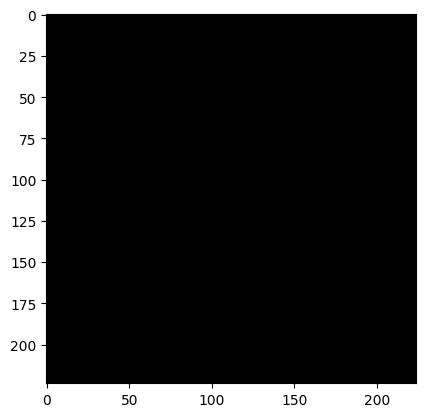

In [563]:
f = os.listdir("images_train_comp_crop_png")[0]
f_split = f.split("_")
print(f)
print(f_split[0:5])     # ta bort crop-info
print(f_split[5])
root_dir = "images_train_comp_crop_png"
plt.imshow(mpimg.imread(os.path.join(root_dir, str(f))))

In [572]:
class ImagesAndLabelsDataset(Dataset):
    def __init__(self, csv_file, root_dir, patches, transform=None):    # num_patches=(1080//224, 1920//224)
        self.annotations = pd.read_csv(csv_file)  # labels
        self.root_dir = root_dir  # image folder
        self.patches = patches
        self.transform = transform
      
    def __len__(self):
        return len(self.annotations)
  
    def __getitem__(self, index):
        for im in patches: 
            
            self.dense_layers = nn.ModuleList([nn.Sequential(
            nn.Linear(50176, 1024),            
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1)
            )]
      
            # unfreeze the last Dense layers:
            for dense in self.dense_layers:
                for param in dense.parameters():
                    param.requires_grad = True
                    
                    
            img_path = os.listdir(self.root_dir)[index]
            # List with compression info, movie name and frame number.
            movie_frame_info = img_path.split("_")[0:5]  
            
            try:
                image = mpimg.imread(os.path.join(root_dir, str(img_path)))
                
            except Exception as e:
                print(f"Error reading image at index {index}: {e}")
                return None
            
            norm = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])   # From https://pytorch.org/hub/pytorch_vision_densenet/
        
            if self.transform:
                image = self.transform(im)
                norm(image)
        
        # VMAF score based on the full frame
        full_frame_vmaf = self.annotations.iloc[index, 0]
            
        patches_tensor = torch.stack(patches)  
        full_frame_vmaf_tensor = torch.tensor(full_frame_vmaf, dtype=torch.float32)
        movie_frame_info_tensor = torch.tensor(movie_frame_info.encode(), dtype=torch.uint8)
          
        return (patches_tensor, full_frame_vmaf_tensor, movie_frame_info)    

In [573]:
data = ImagesAndLabelsDataset(csv_file = "vmaf_on_full_frames_train.csv", root_dir = "images_train_comp_crop_png", patches = patches, transform = transforms.ToTensor())
train_set, val_set = torch.utils.data.random_split(data, [0.9, 0.1], generator=torch.Generator().manual_seed(1))    # 10% validation
train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=100)   
val_loader = DataLoader(dataset=val_set, shuffle=True, batch_size=100) 


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = DenseNet(num_channels=3)       # (num_patch, 3, 224, 224)

model2.to(device)

criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001) 


In [1251]:
train_losses = []
val_losses = []
batch_running_losses = []
num_epochs = 5  

for epoch in range(num_epochs):
    start_epoch_time = time.time()
    model.train()
    running_loss = 0.0     # nollställs för varje epoch
    
    torch.manual_seed(2)        
    for i, data in enumerate(train_loader, 0):      # 0 is start index, 234 is end
        batch_running_loss = 0.0
        
        inputs, labels, info = data
        inputs, labels = inputs, labels
        optimizer.zero_grad()  
        
        outputs = model(inputs)     
        
        training_loss = criterion(outputs, labels)
        train_losses.append(training_loss.item()) 
        running_loss += training_loss.item()
        batch_running_loss += training_loss.item()
        
        with open("train3.txt", "a") as f:
                f.write(str(training_loss.item()))
                f.write('\n')
        
        training_loss.backward()     # backward pass
        
        optimizer.step()             # step
        
              
        val_loss = evaluate(model, val_loader)
        val_losses.append(val_loss)    
        with open("val3.txt", "a") as f2:
            f2.write(str(val_loss))
            f2.write('\n')
                
        model.train()
            
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, batch_running_loss / 25))
        batch_running_losses.append(batch_running_loss / 25)
        batch_running_loss = 0.0
            
        
        avg_loss_per_epoch = running_loss / len(train_loader)
        """if i % 100 == 0:
            epoch_loss = running_loss / len(train_losses)
            # print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss}, Validation Loss: {val_loss}")
            with open("train.txt", "a") as f:
                f.write(str(running_loss / 100))
                f.write('\n')
            running_loss = 0.0"""
        
    end_epoch_time = time.time()  # End timer for epoch
    epoch_time = end_epoch_time - start_epoch_time
    print(f"Epoch {epoch+1} took {epoch_time} seconds")
    print(f"Avg loss for epoch {epoch+1} is  {avg_loss_per_epoch}")


print("Done!")

TypeError: new(): invalid data type 'bytes'

In [1239]:
train_losses = []
val_losses = []
batch_running_losses = []
num_epochs = 5  

for epoch in range(num_epochs):
    start_epoch_time = time.time()
    model.train()
    running_loss = 0.0  
    
    torch.manual_seed(2)        
    for i, data in enumerate(train_loader, 0):  
        inputs, labels, info = data
        inputs, labels = inputs.to(device), labels.to(device)  
        optimizer.zero_grad()  
        
        outputs = model(inputs)
        
        training_loss = criterion(outputs, labels)
        train_losses.append(training_loss.item()) 
        running_loss += training_loss.item()
        
        training_loss.backward()
        optimizer.step()
        
        batch_running_losses.append(training_loss.item())
            
        if i % 25 == 24:  # Print every 25 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 25))
            running_loss = 0.0
        
    end_epoch_time = time.time()
    epoch_time = end_epoch_time - start_epoch_time
    print(f"Epoch {epoch+1} took {epoch_time} seconds")
    
    # Evaluate on validation set after each epoch
    val_loss = evaluate(model, val_loader)
    val_losses.append(val_loss)
    print(f"Avg validation loss for epoch {epoch+1} is {val_loss}")

print("Training done!")


AttributeError: 'list' object has no attribute 'to'